# Phase 1 

### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

### Now load the pickle data into dataframes from the Output folder one directory above

In [2]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()
display(all_projects_bugreports.iloc[0])
display(all_projects_source_codes.iloc[2])
display(all_projects_bugreports.iloc[0].name)
display(all_projects_source_codes.iloc[2].name)

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


fix                  [org.apache.commons.collections.map.flat3map.j...
text                                                               NaN
fixdate                                            2006-07-18 22:02:11
summary              Flat3Map.Entry.setValue() overwrites other Ent...
description          Flat3Map&amp;apos;s Entry objects will overwri...
project                                                    COLLECTIONS
average_precision                                                    0
Name: 217, dtype: object

filename            \gitrepo\src\java\org\apache\commons\collectio...
unprocessed_code    /*\n *  Licensed to the Apache Software Founda...
project                                                   COLLECTIONS
Name: 2, dtype: object

'217'

2

In [3]:
# need to get the file names in the bug report an source code to be the same

# there is no index connection between bugreports index (.name) and the index of the source code
display(all_projects_bugreports.iloc[0].fix)
display(all_projects_source_codes.iloc[217].filename)


array(['org.apache.commons.collections.map.flat3map.java',
       'org.apache.commons.collections.map.testflat3map.java'],
      dtype='<U52')

'\\gitrepo\\src\\java\\org\\apache\\commons\\collections\\list\\transformedlist.java'

## Removing composite varaibles

In [4]:
import re
#remove next line characters:
def remove_new_lines(text):
#     return str(x).replace('\n', '').replace('*', '').replace('/', '').replace('\\','').replace('\t','')
    text = str(text)
    COMBINE_WHITE_SPACE = re.compile(r"(?a:\s+)")
    text = COMBINE_WHITE_SPACE.sub(' ', text)
    return text.replace('*', '').replace('/', '').replace('\\','')
    
# clean up the various white space and remove some *
def clean_new_lines_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(remove_new_lines)
    return df

# clean up the description and summary, they will both be used for the query
def clean_new_lines_bug_report(df):
    df.summary = df.summary.apply(remove_new_lines)
    df['description'] = df['description'].astype('|S')
    df.description = df.description.apply(remove_new_lines)
    return df

# need to reformat the source code so it can be compared to the bug reports fix array
def format_sc_filename(x):
  
    x = x.split('apache')
    if len(x) != 2:
        x = x[0].split('springframework')
        if len(x) != 2:
            x = x[0].split('wildfly')
            if len(x) == 2:
                x = 'org.wildfly' + x[1]
        else:
             x = 'org.springframework' + x[1]
    else:
         x = 'org.apache' + x[1]
    if len(x) == 1:
        x = x[0]
   
    x = str(x).replace("\\",".")
    return x

# apply the fixes to the filename 
def clean_sc_filepath(df):
    df.filename = df.filename.apply(format_sc_filename)
    return df



In [5]:
#splitting composite words
def findCompositeWords(s):
    return ' '.join(re.findall('[A-Z][^A-Z]*', s))   


def clean_composite_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(findCompositeWords)
    return df

def clean_composite_bug_report(df):
    df.summary = df.summary.apply(findCompositeWords)
    df.description = df.description.apply(findCompositeWords)
    return df


In [6]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# add the Java key words to the stop words
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte", "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum", "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected", "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", "<=", ">=", ".", "[", "]", "(",")", "!", "~","instanceof", "<<", ">>", ">>>", "&", "^", "|", "&&", "||", "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]
stop = java_keywords + java_operators
STOP_WORDS = ENGLISH_STOP_WORDS.union(stop)
# STOP_WORDS


### Start working on TF-IDF and Cosine similarity calculations

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# clean up the unprocessed code column
def clean_source_df(df):
    df = clean_new_lines_source_code(df)
    df = clean_composite_source_code(df)
    df = clean_sc_filepath(df)
    return df

# add the summary and description together and clean the data
def clean_combine_bug_df(df):
    df = clean_new_lines_bug_report(df)
    df = clean_composite_bug_report(df)
    df["query"] = df["summary"] + df["description"]
    return df

# get clean versions of the dataframes
sc_df = clean_source_df(all_projects_source_codes)
br_df = clean_combine_bug_df(all_projects_bugreports)


# get a list of the projects 
print(sc_df.project.unique())
projects = sc_df.project.unique()

# group the data frames
# TODO ignore index here? Then maintain original index and concat the data frames
sc_grouped_df = sc_df.groupby(sc_df.project)
bg_grouped_df = br_df.groupby(br_df.project)

# example of getting a data frame for a single project
col_df = sc_grouped_df.get_group("COLLECTIONS")
display(col_df)




['COLLECTIONS' 'CONFIGURATION' 'IO' 'LANG' 'DATACMNS' 'DATAMONGO'
 'DATAREST' 'LDAP' 'SEC' 'SOCIALFB' 'SPR' 'ELY']


,filename,unprocessed_code,project
0,org.apache.commons.collections.arraystack.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
1,org.apache.commons.collections.bag.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
2,org.apache.commons.collections.bagutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
3,org.apache.commons.collections.beanmap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
4,org.apache.commons.collections.bidimap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
...,...,...,...
471,org.apache.commons.collections.set.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS
472,org.apache.commons.collections.set.testtypedse...,Licensed to the Apache Software Foundation ...,COLLECTIONS
473,org.apache.commons.collections.set.testtypedso...,Licensed to the Apache Software Foundation ...,COLLECTIONS
474,org.apache.commons.collections.set.testunmodif...,Licensed to the Apache Software Foundation ...,COLLECTIONS


In [8]:
from sklearn.metrics.pairwise import cosine_similarity


def calculate_similarity(src_vect, query):
    cosSim = cosine_similarity(query, src_vect).flatten()
    return cosSim

# fit the vectorizer and transform data
def get_similarity(vect, src_vect, query_data):
    query = vect.transform(query_data)
    similarity = calculate_similarity(src_vect,query)
     
    return similarity

# remove the stem and stop words
# takes in an array of strings returns an array of strings
def stem_stop(text):
    stemmer = PorterStemmer()   #"english"
    text = text.split()
    text = [w for w in text if not w in STOP_WORDS]
    text = list(map(lambda x: stemmer.stem(x), text))
    text = ' '.join(text)
    text = text.strip()
    return text

# take in the source code df for a project and a signle query return scores
def generate_scores_list(source, query):
    scores_list = [] 
    # get a list of strings from the data frames to be vectorized
    source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
    query["query"] = query["query"].map(stem_stop)
    query_str = query["query"].iloc[0]
     
    # fit a vectorizer to the data
    vect = TfidfVectorizer(min_df=1).fit(source['unprocessed_code'])
    src_vect = vect.transform(source['unprocessed_code'])
#     display(src_vect)
    
    #get the similarity scores for the bug reports    
    #iterate through the query
    for q in query["query"]:
        similarity = get_similarity(vect, src_vect, [q])
        scores_list.append(similarity)
        # some sort of data structure (dict) to collect the queries to add it to the dataframe later
#         display(similarity)
    return scores_list


def rank_sim_scores(scores):
    sim_scores = list()

#     print(len(scores)) # number of bug reports
    for score in scores:
        indicies = range(len(score))
#         print(len(score)) # number of source code files for this project
        scores_tuple = tuple(zip(score,indicies))
        sorted_tuple = sorted(scores_tuple, reverse = True)
#         display(sorted_tuple)
        sim_scores.append(sorted_tuple)
    
    return sim_scores

# look through the src data frame to find where the fix is. 
def get_fix_indexes(bug, src):
    fix_list = list()
    for fixes in bug["fix"]:
#         print(fixes)
        fix_sub=list()
        for fix in fixes:
#             print(fix)
            df = src[src["filename"].str.match(fix)]
            if(df.shape[0] != 0):
                fix_sub.append(df.index[0])
            else:
                fix_sub.append(-1)
#         print(fix_sub)
        fix_list.append(fix_sub)
#     print(fix_list)
    # this is a list of the indexes of the file where the fix was located
    return fix_list
        
        
def average_precision(bug,n=10):
#checks precision for the top n values. If n is too large then this score loses meaning
    ap_list = list()
    for index, row in bug.iterrows():
        countTrue = 0
        for i in range(len(row['ranked_sim'])):
            if i >= n:
                break
            # check if source file is actually where bug is located
            if(row['ranked_sim'][i][1] in row['fix_indexes']):
                countTrue+=1
        ap_list.append(countTrue/n)
    return ap_list

def reciprocal_rank(bug):
#reciprocal rank is 1/n, where n is the first position of a source file where the bug is located in the ranked_sim column
    rr_list = list()
    for index, row in bug.iterrows():
        rr = 0
        for i in range(len(row['ranked_sim'])):
            # check if source file is actually where bug is located
            if(row['ranked_sim'][i][1] in row['fix_indexes']):
                rr = 1/(i+1)
                break
        rr_list.append(rr)
    return rr_list


def generate_all_scores():
    
    all_bugs = []
    all_src = []
    # iterate through the list of 12 projects
    for proj in projects:
        # create dataframes for each project
        src_df = sc_grouped_df.get_group(proj)
        bug_df = bg_grouped_df.get_group(proj).copy()
        
        # generate the scores list
        scores = generate_scores_list(src_df, bug_df)
    
        #append scores list to the bug dataframe
        bug_df["sim_vect"] = scores # the only way that the matrix is related to the src code 
                                    # is through the index.
        
        # Rank the source code files and know what file(s) the bug was in
        bug_df["ranked_sim"] = rank_sim_scores(scores)
        display(bug_df["ranked_sim"])
        # get list of where the fixes rank
        bug_df["fix_indexes"] = get_fix_indexes(bug_df, src_df)
        display(bug_df)
        #get location of the fix indexes within the ranked_sim
        
        # CALCULATE THE MAP AND MRR HERE WITH A FUNCTION AND ADD IT TO THE BUGS DATAFRAME
        bug_df["average_precision_1"] = average_precision(bug_df,1)
        bug_df["average_precision_3"] = average_precision(bug_df,3)
        bug_df["average_precision_5"] = average_precision(bug_df,5)
        bug_df["average_precision_10"] = average_precision(bug_df,10)

        bug_df["reciprocal_rank"] = reciprocal_rank(bug_df)
        
        # maintain a list of all the dataframes
        all_bugs.append(bug_df)
        all_src.append(src_df)
    # concatenate all the data frames in order    
    all_bug_df = pd.concat(all_bugs, ignore_index=True)
    all_src_df = pd.concat(all_src, ignore_index=True)
    return all_bug_df, all_src_df

## TODO list
- Figure out index of the top 20 in the bug sim_vect
- Figure out index of files where the fix was ( this is in the bug report )
- Calculate MAP and MRR for each
- Generate graphs and report on the findings

In [9]:
bugs, sources = generate_all_scores()

id
217    [(0.4656718955142169, 222), (0.447279509685931...
214    [(0.10345136646680671, 3), (0.0880717932156749...
222    [(0.38644080002864695, 288), (0.37509355439192...
261    [(0.5591516607470604, 305), (0.503968358691063...
264    [(0.6582236412487737, 298), (0.643831204240897...
                             ...                        
577    [(0.12069235153633603, 109), (0.10860615800701...
580    [(0.23762779658622352, 137), (0.22792879438408...
583    [(0.0725756081794044, 60), (0.0442830912391032...
586    [(0.33840731012035485, 427), (0.32327573122239...
597    [(0.2173144095633128, 303), (0.194166721215988...
Name: ranked_sim, Length: 92, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,Flat3 Map. Entry.set Value() overwrites other ...,Flat3 Map&amp;apos;s Entry objects will overw...,COLLECTIONS,0.0,flat3 map. entry.set value() overwrit entri va...,"[0.058548134080555064, 0.08970216513375899, 0....","[(0.4656718955142169, 222), (0.447279509685931...","[233, 436]"
214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,Extended Properties - field include should be ...,"The field ""include"" in Extended Properties is...",COLLECTIONS,0.0,extend properti field includ non-stat privatet...,"[0.013388795565578315, 0.028400683146419893, 0...","[(0.10345136646680671, 3), (0.0880717932156749...","[292, 22]"
222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,Collection Utils remove All is actually retain...,"The remove All( Collection collection, Collec...",COLLECTIONS,0.0,collect util remov all actual retain allth rem...,"[0.04851850840676917, 0.16573102168998424, 0.0...","[(0.38644080002864695, 288), (0.37509355439192...","[303, 288, 15]"
261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,Flat3 Map.remove() does not return the correct...,Flat3 Map m = new Flat3 Map();n m.put( new I...,COLLECTIONS,0.0,flat3 map.remove() doe correct valu size 3flat...,"[0.03731537102786185, 0.046074298711050336, 0....","[(0.5591516607470604, 305), (0.503968358691063...","[233, 436]"
264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,Fast Tree Map forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0,fast tree map forget comparatorin line 359 582...,"[0.016509059582201484, 0.016813266781609673, 0...","[(0.6582236412487737, 298), (0.643831204240897...",[27]
...,...,...,...,...,...,...,...,...,...,...,...
577,[org.apache.commons.collections4.trie.patricia...,NaN,2015-09-28 09:45:19,Patricia Trie bugs when only a few bits change,"I have a bug report for you, for the class Ab...",COLLECTIONS,0.0,"patricia trie bug bit changei bug report you, ...","[0.0264495015828069, 0.06419356614392692, 0.00...","[(0.12069235153633603, 109), (0.10860615800701...",[-1]
580,[org.apache.commons.collections4.multimap.mult...,NaN,2015-11-21 10:02:58,Arbitrary remote code execution with Invoker ...,With Invoker Transformer serializable collect...,COLLECTIONS,0.0,arbitrari remot code execut invok transformerw...,"[0.05176015827563829, 0.11265190941103775, 0.0...","[(0.23762779658622352, 137), (0.22792879438408...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
583,[org.apache.commons.collections4.multimap.mult...,NaN,2015-12-14 07:47:22,"J A V A serialization vulnerability "" C V E-20...",The vulnerability we are talking about is know...,COLLECTIONS,0.0,"J A V A serial vulner "" C V e-2015-4852"" commo...","[0.018726170213306553, 0.025489324635428728, 0...","[(0.0725756081794044, 60), (0.0442830912391032...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


id
214    [(0.23315580619162965, 44), (0.222813202414673...
220    [(0.4728875130121734, 20), (0.4383842872899957...
228    [(0.33258710858771046, 199), (0.32662874906832...
230    [(0.47956041675777716, 101), (0.39158177264962...
233    [(0.40481658531465725, 158), (0.33150359849946...
                             ...                        
622    [(0.3578936443274483, 85), (0.2559812025463081...
632    [(0.31837254475000587, 158), (0.29727680737522...
634    [(0.30631823846047, 1), (0.3009557383930566, 1...
627    [(0.6922626976261211, 172), (0.690829813075270...
640    [(0.25792386181833615, 156), (0.24635408666422...
Name: ranked_sim, Length: 133, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
214,[org.apache.commons.configuration.testbaseconf...,NaN,2006-06-02 02:55:45,Adding an integer and getting it as a long cau...,Try this in a Bean Shell:nbsh % p = new org.a...,CONFIGURATION,0.0,ad integ get caus exceptiontri bean shell:nbsh...,"[0.22281320241467356, 0.11967983155719181, 0.0...","[(0.23315580619162965, 44), (0.222813202414673...","[120, 44, 159]"
220,[org.apache.commons.configuration.testdataconf...,NaN,2006-08-15 20:27:44,"Date Array( String key, Date[] default Value,...","Date Array( String key, Date[] default Value,...",CONFIGURATION,0.0,"date array( string key, date[] value, string f...","[0.2133006449069484, 0.04336703286256208, 0.03...","[(0.4728875130121734, 20), (0.4383842872899957...","[135, 20]"
228,[org.apache.commons.configuration.abstracthier...,NaN,2006-10-16 20:26:45,X M L Configuration.subset() with File Change...,X M L Configuration.subset() with File Change...,CONFIGURATION,0.0,X M L configuration.subset() file chang reload...,"[0.053506835469580544, 0.1700085416215588, 0.1...","[(0.33258710858771046, 199), (0.32662874906832...","[2, 168]"
230,[org.apache.commons.configuration.tree.xpath.t...,NaN,2006-10-21 15:23:54,X Path Expression Engine node Key method creat...,In org.apache.commons.configuration.tree.xpath...,CONFIGURATION,0.0,X path express engin node key method creat wro...,"[0.14768536060154439, 0.14213074635185843, 0.0...","[(0.47956041675777716, 101), (0.39158177264962...","[217, 168, 101]"
233,[org.apache.commons.configuration.testcomposit...,NaN,2006-10-28 15:11:24,Incomplete interpolation in Composite Configu...,Interpolsation is mostly done by Abstract Con...,CONFIGURATION,0.0,incomplet interpol composit configuration.get ...,"[0.22292038608066203, 0.10174021330155088, 0.0...","[(0.40481658531465725, 158), (0.33150359849946...","[125, 6]"
...,...,...,...,...,...,...,...,...,...,...,...
622,[org.apache.commons.configuration2.iniconfigur...,NaN,2016-04-16 15:02:56,"Writing I N I file, keys with . become ..",Here is sample input config:n[learningtask]ntr...,CONFIGURATION,0.0,"write I N I file, key ..here sampl input confi...","[0.15075777613595112, 0.08455167744081879, 0.0...","[(0.3578936443274483, 85), (0.2559812025463081...","[-1, -1]"
632,[org.apache.commons.configuration2.compositeco...,NaN,2016-05-27 18:46:00,Composite configuration list variable interpol...,"Composite Configuration.get String Array, with...",CONFIGURATION,0.0,composit configur list variabl interpol elemen...,"[0.22012750888311744, 0.05380179813170292, 0.0...","[(0.31837254475000587, 158), (0.29727680737522...","[-1, -1]"
634,[org.apache.commons.configuration2.io.fileloca...,NaN,2016-06-24 15:52:33,Base Path is incorrectly computed while init o...,"The base path should be just ""app"" instead of ...",CONFIGURATION,0.0,base path incorrectli comput init composit con...,"[0.08917308068530758, 0.30631823846047, 0.1442...","[(0.30631823846047, 1), (0.3009557383930566, 1...","[-1, -1]"


id
83     [(0.1443172904905684, 4), (0.09686583572361723...
90     [(0.7039782565897457, 4), (0.40275065477824284...
91     [(0.49236508239973115, 4), (0.4310825413375522...
93     [(0.23281292378534482, 49), (0.222956580125808...
96     [(0.4033173760377858, 78), (0.2477563159392748...
                             ...                        
484    [(0.3550999878165109, 47), (0.2258156161261254...
492    [(0.2126584813648012, 47), (0.1726280270386134...
494    [(0.14950411519110665, 14), (0.129537265889307...
502    [(0.11678094770118203, 5), (0.1007893197118989...
512    [(0.6490579093540119, 34), (0.5185645284159798...
Name: ranked_sim, Length: 91, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
83,[org.apache.commons.io.filesystemutilstestcase...,NaN,2006-08-25 21:44:03,Bug with &apos;df&apos; command on A I X 5.3,Reported via commons-owner@n------------------...,IO,0.0,bug &apos;df&apos; command A I X 5.3report com...,"[0.07539367732110494, 0.0063852544429664196, 0...","[(0.1443172904905684, 4), (0.09686583572361723...","[49, 4]"
90,[org.apache.commons.io.filesystemutilstestcase...,NaN,2006-08-26 00:06:22,Infinite loop in File System Utils.free Space...,When using File System Utils.free Space Windo...,IO,0.0,infinit loop file system utils.fre space windo...,"[0.13176186890132005, 0.057507394823933876, 0....","[(0.7039782565897457, 4), (0.40275065477824284...","[49, 4]"
91,[org.apache.commons.io.filesystemutilstestcase...,NaN,2006-08-29 20:52:38,File System Utils.free Space does not work on ...,The method File System Utils.free Space does ...,IO,0.0,file system utils.fre space doe work sun solar...,"[0.03022667659016459, 0.006397142557761881, 0....","[(0.49236508239973115, 4), (0.4310825413375522...","[49, 4]"
93,[org.apache.commons.io.filesystemutilstestcase...,NaN,2006-10-07 11:59:33,File System Utils needs to call Process.destr...,Calling the File System Utils.get Free Space(...,IO,0.0,file system util need process.destroy() exec&a...,"[0.08700277635127233, 0.014920533807064535, 0....","[(0.23281292378534482, 49), (0.222956580125808...","[49, 4]"
96,[org.apache.commons.io.testtools.filebasedtest...,NaN,2006-10-11 16:30:49,Test case misuses read(byte[]) and read(char[]),Message to mailing list from Anthony Greennh...,IO,0.0,test misus read(byte[]) read(char[])messag mai...,"[0.11641035816540596, 0.07742284778470652, 0.0...","[(0.4033173760377858, 78), (0.2477563159392748...",[78]
...,...,...,...,...,...,...,...,...,...,...,...
484,[org.apache.commons.io.filenameutilstestcase.j...,NaN,2015-08-06 11:48:50,Filename Utils should handle embedded null bytes,File Name Utils',IO,0.0,filenam util handl embed null bytesfil name ut...,"[0.021956907362549852, 0.001942601789168746, 0...","[(0.3550999878165109, 47), (0.2258156161261254...","[47, 3]"
492,[org.apache.commons.io.ioutils.java],NaN,2015-12-29 15:40:37,"Typo: In an I O Utils.java comment it says ""...",See here: https:github.comapachecommons-ioblob...,IO,0.0,"typo: In I O utils.java comment say ""focussed""...","[0.0596185978041052, 0.003560938560003, 0.0074...","[(0.2126584813648012, 47), (0.1726280270386134...",[-1]
494,[org.apache.commons.io.directorywalker.java],NaN,2016-01-07 21:18:17,Mismatch return type in api docs of class Dir...,In the api docs of class org.apache.commons.io...,IO,0.0,mismatch type api doc class directori walker.i...,"[0.110976739592103, 0.007121015164650417, 0.02...","[(0.14950411519110665, 14), (0.129537265889307...",[-1]


id
261     [(0.28105250858081515, 142), (0.25087591470289...
100     [(0.628957300514116, 17), (0.5702296597481109,...
59      [(0.43312207465973035, 233), (0.34926032191881...
271     [(0.26564781924783387, 131), (0.19949989627882...
259     [(0.5459522755873255, 12), (0.3528836211397922...
                              ...                        
1188    [(0.22184751714908688, 73), (0.199007027559982...
1269    [(0.27149363232360074, 193), (0.21631570612279...
1281    [(0.4634333185517182, 138), (0.317290156249210...
1285    [(0.6713539280985087, 236), (0.635229577393574...
1287    [(0.5601993730976251, 17), (0.4586093867852621...
Name: ranked_sim, Length: 217, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
261,"[org.apache.commons.lang.stringutilstest.java,...",NaN,2006-06-06 02:37:22,Error in an example in the javadoc of the Str...,There is an error in the javadoc of the org.ap...,LANG,0.0,error exampl javadoc string utils.split preser...,"[0.01856874234950177, 0.027990785551905154, 0....","[(0.28105250858081515, 142), (0.25087591470289...","[-1, -1]"
100,[org.apache.commons.lang.randomstringutils.jav...,NaN,2006-06-27 07:28:09,Random String Utils.random() family of methods...,Problem are surrogate pairs: n E.g. Random St...,LANG,0.0,random string utils.random() famili method cre...,"[0.019827159526949883, 0.016434351480101902, 0...","[(0.628957300514116, 17), (0.5702296597481109,...","[-1, -1]"
59,[org.apache.commons.lang.time.dateutilstest.ja...,NaN,2006-07-21 05:15:42,Date Utils.truncate method is buggy when deali...,Try to truncate 2004-10-31 01:00:00 M D T by ...,LANG,0.0,date utils.trunc method buggi deal D S T switc...,"[0.010707172035154389, 0.01791434934200427, 0....","[(0.43312207465973035, 233), (0.34926032191881...","[-1, -1]"
271,[org.apache.commons.lang.localeutilstest.java],NaN,2006-08-10 21:25:47,Locale Utils test fails under Mustang,Testsuite: org.apache.commons.lang. Lang Test ...,LANG,0.0,local util test fail mustangtestsuite: org.apa...,"[0.02683072903207083, 0.019180852319783608, 0....","[(0.26564781924783387, 131), (0.19949989627882...",[-1]
259,[org.apache.commons.lang.enums.valuedenumtest....,NaN,2006-08-18 22:21:34,Valued Enum.compare To( Object other) not type...,Valued Enum.compare To( Object other)n is not ...,LANG,0.0,valu enum.compar to( object other) typesaf eas...,"[0.044494572508530235, 0.0335860315964624, 0.0...","[(0.5459522755873255, 12), (0.3528836211397922...","[-1, -1, -1]"
...,...,...,...,...,...,...,...,...,...,...,...
1188,[org.apache.commons.lang3.stringutils.java],NaN,2016-10-23 19:59:46,String Utils#join( T...): warning: [unchecked]...,String Utils.java:3302: warning: [unchecked] ...,LANG,0.0,string utils#join( t...): warning: [unchecked]...,"[0.07715049777533511, 0.04460471954448596, 0.0...","[(0.22184751714908688, 73), (0.199007027559982...",[22]
1269,"[org.apache.commons.lang3.stringutils.java, or...",NaN,2016-10-28 17:23:52,Wrong name or result of String Utils::get Jar...,The name of the method String Utils::get Jaro...,LANG,0.0,wrong result string utils::get jaro winkler di...,"[0.05930543227775654, 0.040142121305718655, 0....","[(0.27149363232360074, 193), (0.21631570612279...","[22, 142]"
1281,[org.apache.commons.lang3.stringutils.java],NaN,2016-11-06 11:20:58,Javadoc of String Utils.ordinal Index Of is c...,Javadoc of String Utils.ordinal Index Of stat...,LANG,0.0,javadoc string utils.ordin index Of contradict...,"[0.030107258466253138, 0.1770832549953721, 0.0...","[(0.4634333185517182, 138), (0.317290156249210...",[22]


id
19     [(0.48278575081533964, 151), (0.44542764080030...
23     [(0.675840856872818, 374), (0.6354451755751456...
38     [(0.4717646263373042, 282), (0.262701562471761...
40     [(0.6528069575410549, 235), (0.489530663519964...
42     [(0.35700302358571145, 368), (0.32089962934556...
                             ...                        
943    [(0.5412562690291778, 151), (0.513984738519936...
848    [(0.3108067238214017, 19), (0.2827915678168649...
951    [(0.18276595990296476, 48), (0.166592492671941...
934    [(0.4926358662697551, 418), (0.475192569681294...
963    [(0.33499915399252045, 152), (0.32437998863092...
Name: ranked_sim, Length: 158, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
19,[org.springframework.data.repository.pagingand...,NaN,2011-03-02 00:11:20,Invalid entity metadata when domain class impl...,Latest snapshot (spring-data-jpa-1.0.0. B U I ...,DATACMNS,0.0,invalid entiti metadata domain class persistab...,"[0.051780758887607053, 0.06002163946749635, 0....","[(0.48278575081533964, 151), (0.44542764080030...","[179, 180, -1, -1, -1]"
23,[org.springframework.data.domain.pageimpl.java...,NaN,2011-03-31 23:41:16,Page Impl can not be constructed with empty co...,When passing empty list to Page Impl construc...,DATACMNS,0.0,page impl construct contentwhen pass list page...,"[0.006637683250997997, 0.006085139495198832, 0...","[(0.675840856872818, 374), (0.6354451755751456...","[70, 374, 68]"
38,[org.springframework.data.mapping.abstractmapp...,NaN,2011-05-18 10:15:43,Stack Overflow Error on self-referencing Objects,"Hi, i get the following error when starting a ...",DATACMNS,0.0,"stack overflow error self-referenc objectshi, ...","[0.10580893728016386, 0.06177963769020931, 0.0...","[(0.4717646263373042, 282), (0.262701562471761...","[-1, -1, 324, 322, 312, 533, -1, -1, 526]"
40,[org.springframework.data.repository.support.a...,NaN,2011-05-24 08:34:56,Rename @ Repository Proxy to @ Repository Defi...,None',DATACMNS,0.0,renam @ repositori proxi @ repositori definiti...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(0.6528069575410549, 235), (0.489530663519964...","[-1, 501, -1, -1, -1, -1]"
42,[org.springframework.data.mapping.beanwrapper....,NaN,2011-06-06 15:52:18,Mapping Context does not map Big Decimal corr...,None',DATACMNS,0.0,map context doe map big decim correctlynone',"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(0.35700302358571145, 368), (0.32089962934556...","[-1, -1, -1]"
...,...,...,...,...,...,...,...,...,...,...,...
943,[org.springframework.data.repository.core.supp...,NaN,2016-11-24 16:25:00,Redeclared save( Iterable) results in wrong me...,I have upgrade my project from spring boot 1.3...,DATACMNS,0.0,redeclar save( iterable) result wrong method o...,"[0.08391985424159, 0.0778139594060973, 0.07725...","[(0.5412562690291778, 151), (0.513984738519936...","[220, 471]"
848,[org.springframework.data.convert.jsr310conver...,NaN,2016-12-05 08:51:16,Support J S R-310 Duration and Period (to a...,The current Jsr310 Converters.java doesn&amp;...,DATACMNS,0.0,support J S r-310 durat period (to string)th c...,"[0.0443732407553895, 0.05057084137583423, 0.05...","[(0.3108067238214017, 19), (0.2827915678168649...","[46, 367]"
951,[org.springframework.data.convert.jsr310conver...,NaN,2016-12-05 15:35:07,Add Converters for J S R-310 Duration and ...,None',DATACMNS,0.0,add convert J S r-310 durat periodnone',"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(0.18276595990296476, 48), (0.166592492671941...","[46, 367]"


id
273     [(0.461878511109809, 280), (0.4407226823567148...
294     [(0.4082560437195211, 223), (0.190573311929165...
316     [(0.6395658244296727, 9), (0.6128107299633535,...
306     [(0.33340225199883733, 213), (0.31281607225202...
315     [(0.37892458558636866, 154), (0.31702619472430...
                              ...                        
1513    [(0.5452445243981746, 276), (0.508535572013213...
1500    [(0.39461699778714115, 153), (0.37223329395925...
1521    [(0.21588024001276934, 116), (0.19165743340941...
1534    [(0.2538486663666388, 165), (0.214918240035956...
1565    [(0.3817462408062211, 276), (0.360033297890771...
Name: ranked_sim, Length: 271, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
273,[org.springframework.data.mongodb.core.convert...,NaN,2011-10-11 04:25:21,Collection elements seem to lost their type wh...,When I persist a list of objects they do not ...,DATAMONGO,0.0,collect element lost type persistedwhen I pers...,"[0.04165471438570245, 0.0062813515000857975, 0...","[(0.461878511109809, 280), (0.4407226823567148...",[-1]
294,[org.springframework.data.mongodb.core.convert...,NaN,2011-10-13 09:05:20,List elements nested in Map lose their type w...,"Possibly related to D A T A M O N G O-273, ob...",DATAMONGO,0.0,list element nest map lose type persistedposs ...,"[0.004656169952694837, 0.003842146791802098, 0...","[(0.4082560437195211, 223), (0.190573311929165...",[-1]
316,[org.springframework.data.mongodb.config.mongo...,NaN,2011-11-14 13:38:08,Replica Set configuration via properties file...,Mongo Replica Set configuration via propertie...,DATAMONGO,0.0,replica set configur properti file array index...,"[0.015877361706726253, 0.01741794117850124, 0....","[(0.6395658244296727, 9), (0.6128107299633535,...","[13, -1, 173]"
306,[org.springframework.data.mongodb.config.mongo...,NaN,2011-11-14 19:47:51,Null Pointer Exception if mongo factory create...,Configuring mongo data factory with a U R I t...,DATAMONGO,0.0,null pointer except mongo factori creat U R I ...,"[0.139328388401939, 0.07791721469655562, 0.076...","[(0.33340225199883733, 213), (0.31281607225202...","[172, 41]"
315,[org.springframework.data.mongodb.core.mongote...,NaN,2011-11-14 20:30:06,Mongo Template.find One(query) methods ignore ...,"Query query = query(where(""type"").is(""ad""));nq...",DATAMONGO,0.0,mongo template.find one(query) method ignor so...,"[0.019301637262810013, 0.008683137040430585, 0...","[(0.37892458558636866, 154), (0.31702619472430...","[192, 39]"
...,...,...,...,...,...,...,...,...,...,...,...
1513,[org.springframework.data.mongodb.core.mongote...,NaN,2016-11-03 08:16:02,Non- Object Id identifiers generated by event ...,We have observed issues when persisting multip...,DATAMONGO,0.0,non- object Id identifi gener event listen pop...,"[0.02094051257003031, 0.008308995523330046, 0....","[(0.5452445243981746, 276), (0.508535572013213...","[192, 39]"
1500,[org.springframework.data.mongodb.repository.q...,NaN,2016-11-03 08:37:57,Runtime Exception for query methods with field...,When I upgrade from version 1.8.4. R E L E A ...,DATAMONGO,0.0,runtim except queri method field declar pageab...,"[0.049967780771922765, 0.03709789784508038, 0....","[(0.39461699778714115, 153), (0.37223329395925...","[-1, 153]"
1521,[org.springframework.data.mongodb.core.aggrega...,NaN,2016-11-03 14:05:28,Aggregation.skip(...) expects int but new Ski...,Currently the class Skip Operation takes an l...,DATAMONGO,0.0,aggregation.skip(...) expect skip operation(.....,"[0.0005427055706525631, 0.0006117857063579902,...","[(0.21588024001276934, 116), (0.19165743340941...","[-1, -1, -1]"


id
23     [(0.40012432265720416, 77), (0.392445486338773...
21     [(0.27774937518312637, 312), (0.27395354629481...
41     [(0.2857860122350136, 159), (0.222451186376427...
45     [(0.22971289864694402, 240), (0.16960755049596...
38     [(0.1494588486526988, 240), (0.134581438051345...
                             ...                        
937    [(0.23960663587204478, 176), (0.23829075819102...
938    [(0.3944444246383264, 138), (0.205197455753854...
953    [(0.32013982354372544, 30), (0.199188710883224...
956    [(0.2762116172032765, 30), (0.2018946269773551...
958    [(0.17147158598769477, 21), (0.154484488333747...
Name: ranked_sim, Length: 132, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
23,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:48:16,Searches which returns null gives N P E,A search which returns null gives Null Pointe...,DATAREST,0.0,search return null give N P EA search return n...,"[0.023132469973543318, 0.01312116811644595, 0....","[(0.40012432265720416, 77), (0.392445486338773...",[139]
21,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:49:25,,By in href .prev and .nextn Page&lt; Loan Info...,DATAREST,0.0,By href .prev .nextn page&lt; loan info&gt; By...,"[0.022247483077878626, 0.0, 0.0034034813771508...","[(0.27774937518312637, 312), (0.27395354629481...","[-1, -1, 152, -1, -1, 142, -1, 139, -1]"
41,[org.springframework.data.rest.webmvc.json.rep...,NaN,2012-09-05 06:07:58,No update on objects,"When I try to update an object, the only thin...",DATAREST,0.0,"No updat objectswhen I updat object, think hap...","[0.028293803625791068, 0.0, 0.1069652761073853...","[(0.2857860122350136, 159), (0.222451186376427...",[-1]
45,[org.springframework.data.rest.webmvc.entityto...,NaN,2012-09-05 06:09:20,No I Ds in href of objects displayed,Browsing to: http:localhost:8080restsla result...,DATAREST,0.0,No I Ds href object displayedbrows to: http:lo...,"[0.024320433300272903, 0.0, 0.0196223391108284...","[(0.22971289864694402, 240), (0.16960755049596...","[-1, 139]"
38,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-05 06:29:43,Listing relations with Accept:applicationx-sp...,When loading a relation like this: nhttp:local...,DATAREST,0.0,list relat accept:applicationx-spring-data-com...,"[0.015194685519929417, 0.019725218796311738, 0...","[(0.1494588486526988, 240), (0.134581438051345...",[139]
...,...,...,...,...,...,...,...,...,...,...,...
937,[org.springframework.data.rest.webmvc.json.dom...,NaN,2016-12-06 08:49:35,Transient properties in J S O N should be inc...,When using the repository domain object update...,DATAREST,0.0,transient properti J S O N includ mergewhen us...,"[0.0575014051349833, 0.013128974547781657, 0.0...","[(0.23960663587204478, 176), (0.23829075819102...","[296, 168]"
938,[org.springframework.data.rest.webmvc.json.dom...,NaN,2016-12-07 17:57:17,Nested entities are replaced with new instance...,When using the repository domain object update...,DATAREST,0.0,nest entiti replac instanc instead updat mergi...,"[0.05744003187044647, 0.005406276522817488, 0....","[(0.3944444246383264, 138), (0.205197455753854...","[296, 168]"
953,[org.springframework.data.rest.webmvc.json.dom...,NaN,2016-12-07 17:58:13,P U T empties nested collection,In the following scenario Parent and Child a...,DATAREST,0.0,P U T empti nest collectionin follow scenario ...,"[0.001706125906207984, 0.0034123199971163565, ...","[(0.32013982354372544, 30), (0.199188710883224...",[296]


id
26     [(0.4061213152888272, 55), (0.3514795315986699...
15     [(0.4553004848681104, 274), (0.454024879614414...
37     [(0.7751922995084781, 51), (0.6104279429465098...
46     [(0.3360145692324042, 81), (0.2873490778330751...
13     [(0.2810151111911879, 75), (0.2546878789443092...
66     [(0.5668062776399034, 50), (0.5504714234482452...
83     [(0.44743036556028093, 292), (0.31946200651416...
93     [(0.49596435822311147, 370), (0.43658542417964...
100    [(0.35909768060453995, 40), (0.353175181592752...
102    [(0.4919056797017911, 94), (0.4547006443370565...
96     [(0.36097088810622824, 3), (0.3379409376304682...
109    [(0.2661289383667827, 467), (0.212970746018278...
50     [(0.2731339362203755, 285), (0.261589650090780...
134    [(0.3262322520742047, 94), (0.3250442237089695...
121    [(0.5979621449106288, 323), (0.472968255981909...
114    [(0.2698300113950828, 189), (0.253172216128155...
122    [(0.5814029275820537, 241), (0.574602807510365...
97     [(0.34298041415996494

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
26,[org.springframework.ldap.ldaptemplatetest.jav...,NaN,2007-01-10 04:17:20,Paged Results Request Control failing when use...,Bug raised in response to following post on th...,LDAP,0.0,page result request control fail use A dbug ra...,"[0.06145402713683966, 0.24581704586681075, 0.2...","[(0.4061213152888272, 55), (0.3514795315986699...","[-1, 88]"
15,[org.springframework.ldap.support.dircontextad...,NaN,2007-01-10 04:37:26,Dir Context Adapter.set Attribute(),Dir Context Adapter.set Attribute Value( Strin...,LDAP,0.0,dir context adapter.set attribute() dir contex...,"[0.1854652530964352, 0.04937123981712338, 0.11...","[(0.4553004848681104, 274), (0.454024879614414...","[-1, -1]"
37,[org.springframework.ldap.control.abstractrequ...,NaN,2007-02-06 04:51:17,Controls[] java.lang. Null Pointer Exception w...,Control[] request Controls = ldap Context.get ...,LDAP,0.0,controls[] java.lang. null pointer except perf...,"[0.019291160859286664, 0.3993329057400961, 0.3...","[(0.7751922995084781, 51), (0.6104279429465098...","[-1, 51]"
46,[org.springframework.ldap.core.dircontextadapt...,NaN,2007-04-20 04:52:07,Dir Context Adapter.get Modificatio Items() do...,Dir Context Adapter.get Modication Items() cal...,LDAP,0.0,dir context adapter.get modificatio items() do...,"[0.07180274379191559, 0.07008009277219729, 0.0...","[(0.3360145692324042, 81), (0.2873490778330751...","[74, 274]"
13,[org.springframework.ldap.core.dircontextadapt...,NaN,2007-04-20 04:55:53,Dir Context Adapter.get Modification Items() r...,"Hello,nn We have a Person.java pojo containin...",LDAP,0.0,dir context adapter.get modif items() return p...,"[0.2087238064233349, 0.1254654330806083, 0.140...","[(0.2810151111911879, 75), (0.2546878789443092...","[74, 274]"
66,[org.springframework.ldap.control.pagedresults...,NaN,2007-05-01 05:43:29,Null Pointer Exception when getting Paged Res...,"The problem is similar to L D A P-37, but for...",LDAP,0.0,null pointer except get page result request co...,"[0.03135985688024871, 0.21190551579074057, 0.1...","[(0.5668062776399034, 50), (0.5504714234482452...","[56, -1]"
83,[org.springframework.ldap.core.support.abstrac...,NaN,2007-10-18 06:58:23,Abstract Connection Source should ignore S U ...,If I pass in a base environment to Abstract ...,LDAP,0.0,abstract connect sourc ignor S U N_ L D A P_ P...,"[0.006273278975200381, 0.0051867408464039075, ...","[(0.44743036556028093, 292), (0.31946200651416...","[96, 292]"
93,[org.springframework.ldap.core.simple.simpleld...,NaN,2007-12-07 04:29:54,Simple Ldap Template search method delegates t...,The following method on Simple Ldap Template ...,LDAP,0.0,simpl ldap templat search method deleg incorre...,"[0.12515251065848731, 0.22752990489671385, 0.3...","[(0.49596435822311147, 370), (0.43658542417964...",[371]
100,[org.springframework.ldap.ldapreferralexceptio...,NaN,2008-04-20 00:39:47,Ldap Utils#convert Ldap Exception fails to con...,Ldap Utils#convert Ldap Exception checks wheth...,LDAP,0.0,ldap utils#convert ldap except fail convert na...,"[0.03484231832936939, 0.024971120913666336, 0....","[(0.35909768060453995, 40), (0.353175181592752...","[21, 222]"


id
22      [(0.4204576949614777, 30), (0.4066328607264836...
27      [(0.49617636172352214, 1143), (0.4252787932866...
20      [(0.3383075783061122, 1180), (0.33376159537517...
48      [(0.5087779701773529, 878), (0.501509699282769...
43      [(0.4165427618136085, 35), (0.3266538478046951...
                              ...                        
3147    [(0.32283995852228076, 158), (0.31409319962891...
3160    [(0.4421523138972144, 349), (0.431452311553012...
3159    [(0.15680063080423742, 1121), (0.0793439520080...
3158    [(0.5096043348666628, 1184), (0.35922681555554...
3170    [(0.7564674930382571, 172), (0.601673350659336...
Name: ranked_sim, Length: 541, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
22,[org.acegisecurity.adapters.jboss.jbossacegilo...,NaN,2005-06-26 13:06:38,J Boss Acegi Login Module - Bug when identity...,Currently the code used to create the Princip...,SEC,0.0,J boss acegi login modul bug ident createdcurr...,"[0.101334145208633, 0.045397402001438644, 0.06...","[(0.4204576949614777, 30), (0.4066328607264836...",[-1]
27,[org.acegisecurity.ui.rememberme.remembermepro...,NaN,2005-07-08 08:21:14,Remember Me Processing Filter should not fire ...,I have tried to start my application with the ...,SEC,0.0,rememb Me process filter interact authent succ...,"[0.08255529073504998, 0.03338184996967553, 0.0...","[(0.49617636172352214, 1143), (0.4252787932866...",[-1]
20,[org.acegisecurity.context.httpsessioncontexti...,NaN,2005-07-11 16:46:19,Http Session Context Integration Filter must s...,Http Session Context Integration Filter must s...,SEC,0.0,http session context integr filter set null ir...,"[0.023153658756365, 0.006062434355440043, 0.01...","[(0.3383075783061122, 1180), (0.33376159537517...","[-1, -1]"
48,[org.acegisecurity.providers.jaas.jaasnamecall...,NaN,2005-08-23 02:16:13,Improve Jaas Name Callback Handler handling o...,"I submitted this via the listserv on 7212005, ...",SEC,0.0,improv jaa name callback handler handl string ...,"[0.025186978369223664, 0.013953890323086157, 0...","[(0.5087779701773529, 878), (0.501509699282769...",[-1]
43,[org.acegisecurity.acl.basic.jdbc.jdbcextended...,NaN,2005-10-20 18:32:44,Jdbc Extended Dao Impl doesn&apos;t work with ...,Using Jdbc Extended Dao Impl together with P...,SEC,0.0,jdbc extend dao impl doesn&apos;t work postgre...,"[0.14999048044058916, 0.1423429168777629, 0.17...","[(0.4165427618136085, 35), (0.3266538478046951...",[-1]
...,...,...,...,...,...,...,...,...,...,...,...
3147,[org.springframework.security.config.http.form...,NaN,2015-11-12 21:23:42,Include the error parameter into authenticatio...,"If X M L Config used, parameter that indicat...",SEC,0.0,includ error paramet authentication-failure-ur...,"[0.025489411801762247, 0.00517518003935089, 0....","[(0.32283995852228076, 158), (0.31409319962891...",[203]
3160,[org.springframework.security.web.util.matcher...,NaN,2015-11-29 02:57:29,Invalid H T T P verb throws 500 not 400,Had a few cases of a bad client request which ...,SEC,0.0,invalid H T T P verb 500 400had case bad clien...,"[0.08605493570110317, 0.03908110451771762, 0.0...","[(0.4421523138972144, 349), (0.431452311553012...","[1262, 1270, 1391, 1398]"
3159,[org.springframework.security.config.annotatio...,NaN,2015-11-29 03:00:53,Java doc inaccurate on Http Security#headers,None',SEC,0.0,java doc inaccur http security#headersnone',"[0.01566726801109783, 0.016273053602977018, 0....","[(0.15680063080423742, 1121), (0.0793439520080...",[152]


id
33     [(0.2408063790244172, 45), (0.2310396712017594...
42     [(0.5031022922072373, 104), (0.206740510250076...
75     [(0.6014737672709399, 32), (0.5792161137133891...
80     [(0.3386305297278515, 53), (0.3226849300833272...
92     [(0.4078900493339114, 237), (0.160108559663805...
97     [(0.25055486032161856, 0), (0.218214271127685,...
128    [(0.41208910986388936, 230), (0.24460927043648...
141    [(0.27169454350711303, 226), (0.21461168771241...
138    [(0.3976118007098437, 159), (0.358806632700635...
165    [(0.40665496740380824, 213), (0.37698995177779...
153    [(0.36354310569560155, 144), (0.34180119604483...
163    [(0.39125940883112215, 144), (0.36779627572260...
168    [(0.5652824393613409, 58), (0.5087742584307914...
169    [(0.23420433678054095, 22), (0.194830508876896...
189    [(0.286795873660561, 112), (0.2395032447554063...
Name: ranked_sim, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
33,[org.springframework.social.facebook.api.impl....,NaN,2011-11-07 15:25:27,N P E when F B sends back data for likes inst...,Sometimes Facebook sends back a count for the...,SOCIALFB,0.0,N P E F B send data like instead countsometim ...,"[0.002427785334770079, 0.10963025361230919, 0....","[(0.2408063790244172, 45), (0.2310396712017594...",[162]
42,[org.springframework.social.facebook.api.impl....,NaN,2012-01-30 09:15:11,Facebook Error Handler will be handle 404 Not...,Facebook Error Handler doesn&amp;apos;t handle...,SOCIALFB,0.0,facebook error handler handl 404 not found err...,"[0.013179096945761339, 0.004595560082810438, 0...","[(0.5031022922072373, 104), (0.206740510250076...","[104, 198]"
75,[org.springframework.social.facebook.api.fqlte...,NaN,2012-04-16 13:19:48,"Fql Result.get List( String field Name, Fql R...","Using F Q L to access the stream table, many ...",SOCIALFB,0.0,"fql result.get list( string field name, fql re...","[0.07556967745382166, 0.021434336070158995, 0....","[(0.6014737672709399, 32), (0.5792161137133891...","[-1, 31]"
80,[org.springframework.social.facebook.api.impl....,NaN,2012-05-09 10:34:15,Operation Not Permitted Exception thrown when ...,Facebook has recently started improving its er...,SOCIALFB,0.0,oper not permit except thrown insuffici permis...,"[0.012595012033483163, 0.029330888594376336, 0...","[(0.3386305297278515, 53), (0.3226849300833272...","[104, 198]"
92,[org.springframework.social.facebook.api.impl....,NaN,2012-08-30 13:22:32,Changes to page pictures property will break ...,On 1032012 the Facebook A P I will be change...,SOCIALFB,0.0,chang page pictur properti A P I bindingon 103...,"[0.030800885613523905, 0.02376409256672579, 0....","[(0.4078900493339114, 237), (0.160108559663805...","[152, 179, 206, 93, 70, 162, 200, 73, 158, 205..."
97,[org.springframework.social.facebook.api.impl....,NaN,2012-09-06 21:21:21,Facebook Template.initialize() is called twice...,Facebook Template( String access Token) {ntthi...,SOCIALFB,0.0,facebook template.initialize() call twice cons...,"[0.25055486032161856, 0.010041806835385012, 0....","[(0.25055486032161856, 0), (0.218214271127685,...",[105]
128,[org.springframework.social.facebook.web.canva...,NaN,2013-08-09 09:06:16,Error 405 using Canvas Sign In Controller,Error 405 is encountered using Canvas Sign In...,SOCIALFB,0.0,error 405 use canva sign In controllererror 40...,"[0.008737503654279704, 0.0030467734763824144, ...","[(0.41208910986388936, 230), (0.24460927043648...",[230]
141,[org.springframework.social.facebook.api.liket...,NaN,2014-04-10 13:49:06,Like Operations.get Pages Liked doesn&apos;t g...,I tested directly the fb graph api explorer an...,SOCIALFB,0.0,like operations.get page like doesn&apos;t cov...,"[0.04831546924376236, 0.010326610005126736, 0....","[(0.27169454350711303, 226), (0.21461168771241...","[205, 111]"
138,[org.springframework.social.facebook.api.impl....,NaN,2014-04-10 14:00:09,Jackson Map Exception on checkinposts,Some checkins do not provide a complete locati...,SOCIALFB,0.0,jackson map except checkinpostssom checkin pro...,"[0.016189153195231457, 0.018245525528132963, 0...","[(0.3976118007098437, 159), (0.358806632700635...","[152, -1, 47]"


id
5016     [(0.3089611292749388, 2093), (0.26231798625597...
5171     [(0.24836926297257103, 2372), (0.2371206046912...
5275     [(0.3984694408159063, 3025), (0.38028499605650...
5324     [(0.4633396218140695, 3355), (0.42355785620940...
5332     [(0.5968472018930492, 2950), (0.50187053975012...
                               ...                        
12661    [(0.3902521114224028, 3679), (0.38475189608104...
11598    [(0.41181382643170794, 3743), (0.4044366955734...
14080    [(0.25569801361320044, 5399), (0.1824859050013...
14248    [(0.6127291820046443, 4990), (0.58225778363102...
14678    [(0.46198679479189625, 3899), (0.4590840463831...
Name: ranked_sim, Length: 130, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
5016,[org.springframework.context.config.propertyov...,NaN,2008-07-18 00:36:13,Add more properties to <context:property-place...,This is not enough for advance usage. Please ...,SPR,0.0,add properti <context:property-placeholder>thi...,"[0.018895236441340623, 0.0042251429068469164, ...","[(0.3089611292749388, 2093), (0.26231798625597...","[930, 1604, 931, 924]"
5171,[org.springframework.test.web.abstractmodeland...,NaN,2008-09-21 20:39:19,Incompatible with J Unit 4.5,Spring relies on org.junit. Assume$ Assumption...,SPR,0.0,incompat J unit 4.5spring reli org.junit. assu...,"[0.0, 0.0022176650416439935, 0.004080814397499...","[(0.24836926297257103, 2372), (0.2371206046912...","[-1, -1, -1, 3682, -1, -1, 3679, 3680]"
5275,[org.springframework.jms.support.jmsutils.java],NaN,2008-11-20 08:07:23,Jms Utils.build Exception Message throws N P ...,This method throws an exception if the linked ...,SPR,0.0,jm utils.build except messag N P E link except...,"[0.037570032138930835, 0.00610446687864487, 0....","[(0.3984694408159063, 3025), (0.38028499605650...",[3043]
5324,[org.springframework.orm.hibernate3.annotation...,NaN,2008-11-28 00:05:48,Annotation Session Factory Bean.scan Packages(...,"The ""scan Packages"" property requires the pack...",SPR,0.0,annot session factori bean.scan packages() cre...,"[0.08407022433663679, 0.011296374438914777, 0....","[(0.4633396218140695, 3355), (0.42355785620940...",[3355]
5332,[org.springframework.jms.support.jmsutils.java],NaN,2009-02-11 22:20:13,Jms Exception.get Message throws N P E if a c...,Under some circumstances a J M S Exception m...,SPR,0.0,jm exception.get messag N P E caus doesn&apos;...,"[0.051884823170808586, 0.0044805707241362715, ...","[(0.5968472018930492, 2950), (0.50187053975012...",[3043]
...,...,...,...,...,...,...,...,...,...,...,...
12661,[org.springframework.core.annotation.annotated...,NaN,2015-01-24 09:20:46,Test Execution Listeners is not fully supporte...,Status Quon When using Test N G and deriving...,SPR,0.0,test execut listen fulli support meta-annotati...,"[0.022690516999706728, 0.011234406555702325, 0...","[(0.3902521114224028, 3679), (0.38475189608104...",[2319]
11598,[org.springframework.core.annotation.annotated...,NaN,2015-05-13 07:20:33,Favor more locally declared composed annotatio...,Backgroundn This issue picks up where S P R-1...,SPR,0.0,favor local declar compos annot inherit annota...,"[0.013074858431879789, 0.030393871771143843, 0...","[(0.41181382643170794, 3743), (0.4044366955734...",[2319]
14080,[org.springframework.web.util.uricomponentsbui...,NaN,2016-03-24 13:17:04,Default Cors Processor&apos;s origin compariso...,This plays in part with S P R-13691 but is mo...,SPR,0.0,default cor processor&apos; origin comparison ...,"[0.022368511050644566, 0.008880965495807316, 0...","[(0.25569801361320044, 5399), (0.1824859050013...",[4743]


id
256    [(0.1883274558901454, 61), (0.1262279979850343...
429    [(0.1872651807205134, 4), (0.1745786005365252,...
385    [(0.6600978424038915, 67), (0.1160804935072865...
401    [(0.6511016385488106, 67), (0.1469216251618208...
502    [(0.17506446365851994, 38), (0.076276126276781...
538    [(0.31806495381451017, 32), (0.306025379103459...
395    [(0.46831641900160786, 40), (0.359767588588197...
537    [(0.13735673240630505, 2), (0.0814784967327505...
542    [(0.5505163321756278, 55), (0.4888299156765498...
543    [(0.5168309965816578, 42), (0.4935178981610711...
545    [(0.1290007264393106, 6), (0.07527532636010874...
546    [(0.35164331897607004, 6), (0.2879768109738263...
589    [(0.13603752432409488, 12), (0.111881931349754...
611    [(0.2661231422151541, 32), (0.2550448842718232...
614    [(0.2709803742250482, 32), (0.2443792208762052...
610    [(0.149593432487566, 41), (0.0732772045325982,...
612    [(0.2982388034960097, 42), (0.2781185414427762...
654    [(0.29146833022846214

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,ranked_sim,fix_indexes
id,,,,,,,,,,,
256,[org.wildfly.security.sasl.util.channelbinding...,NaN,2015-08-06 16:08:18,Channel Binding Sasl Client and - Server Facto...,Currently this causes a Fast Unsupported Call...,ELY,0.0,channel bind sasl client server factori pass c...,"[0.0, 0.019271321731496455, 0.0042429311370203...","[(0.1883274558901454, 61), (0.1262279979850343...","[-1, -1]"
429,[org.wildfly.security.auth.provider.ldap.ldaps...,NaN,2016-03-15 08:28:29,Ldap Security Realm Builder.build() should be ...,Class Ldap Security Realm cannot be used from...,ELY,0.0,ldap secur realm builder.build() retunr type i...,"[0.08364994100564117, 0.07427415593388388, 0.0...","[(0.1872651807205134, 4), (0.1745786005365252,...",[-1]
385,[org.wildfly.security.ssl.mechanismdatabase.java],NaN,2016-03-15 08:30:20,"E L Y01077: Invalid alias "" T L S_ R S A_ W I...",W A R N [org.wildfly.security] ( M S C service...,ELY,0.0,"E L y01077: invalid alia "" T L S_ R S A_ W I T...","[0.003584582410397278, 0.0031828095717335893, ...","[(0.6600978424038915, 67), (0.1160804935072865...",[51]
401,[org.wildfly.security.ssl.mechanismdatabase.java],NaN,2016-03-15 08:40:24,"E L Y01077: Invalid alias "" T L S_ R S A_ W I...",Getting the following warning logged when filt...,ELY,0.0,"E L y01077: invalid alia "" T L S_ R S A_ W I T...","[0.0026852687092160715, 0.002384294172057377, ...","[(0.6511016385488106, 67), (0.1469216251618208...",[51]
502,[org.wildfly.security.credential.store.impl.ke...,NaN,2016-04-20 08:12:45,Remove operation doesn&apos;t persist the resu...,Remove operation doesn&amp;apos;t persist the ...,ELY,0.0,remov oper doesn&apos;t persist result keystor...,"[0.07627612627678136, 0.06772682477722512, 0.0...","[(0.17506446365851994, 38), (0.076276126276781...",[-1]
538,[org.wildfly.security.permission.elytronpermis...,NaN,2016-05-27 14:53:25,Infinite loop in Elytron Permission Collectio...,There is infinite loop in Elytron Permission ...,ELY,0.0,infinit loop elytron permiss collection.read r...,"[0.014762196227258424, 0.013107596387139618, 0...","[(0.31806495381451017, 32), (0.306025379103459...","[33, -1, -1]"
395,[org.wildfly.security.ssl.ciphersuiteselector....,NaN,2016-06-01 13:52:37,Undertow H T T P S listener offers no cipher ...,No cipher suites are available for handshake w...,ELY,0.0,undertow H T T P S listen offer cipher suit D ...,"[0.007444830454794847, 0.006610387185610448, 0...","[(0.46831641900160786, 40), (0.359767588588197...",[40]
537,[org.wildfly.security.credential.store.impl.ke...,NaN,2016-06-18 13:31:38,Resource leaks in Keystore Password Store,There are two resource leaks in org.wildfly.se...,ELY,0.0,resourc leak keystor password storether resour...,"[0.006987574135521589, 0.006204381792765455, 0...","[(0.13735673240630505, 2), (0.0814784967327505...",[-1]
542,[org.wildfly.security.ssl.protocolselector.java],NaN,2016-06-18 13:32:25,Incorrectly implemented apply Filter method of...,Method apply Filter from org.wildfly.security....,ELY,0.0,incorrectli implement appli filter method prot...,"[0.004073382557885936, 0.0036168232475188443, ...","[(0.5505163321756278, 55), (0.4888299156765498...",[-1]


## Calculate and graph MRR and MAP

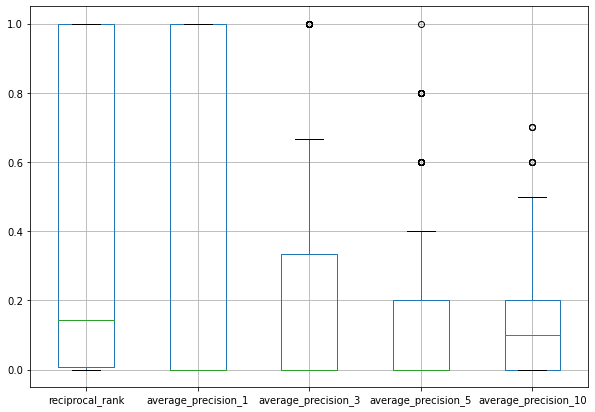

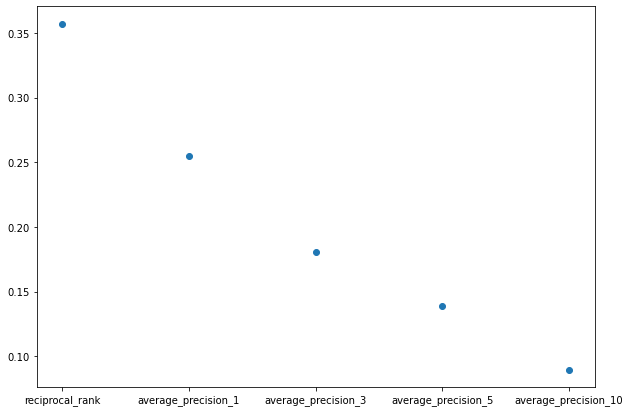

In [22]:
import matplotlib.pyplot as plt
def generate_graphs(bugs):
    # Im not too sure this boxplot is actually useful, at least not for reciprocal_rank and avearge_precision_1
    important_cols = ["reciprocal_rank","average_precision_1","average_precision_3","average_precision_5","average_precision_10"]
    boxplot = bugs.boxplot(column=important_cols,figsize=(10,7))
    mean_list = list()
    for col in important_cols:
        mean_list.append(bugs[col].mean())
    fig, ax = plt.subplots(figsize=(10,7))
    ax.scatter(important_cols,mean_list)
generate_graphs(bugs)

In [29]:
def findBugRanks(bug_vectors, source_codes):
    
    similarity_scores = []
    rank_indexs = []
    
    for project, vect, fixes in zip(bug_vectors['project'],bug_vectors['sim_vect'],bug_vectors['fix']): 
        
        code = sc_grouped_df.get_group(project)
        code = code['filename'].to_numpy()  ## find all code files pertaining to the bug reports project 
        
        z = [code for _,code in sorted(zip(vect,code),reverse=True)] ## sort the list of projects based on the similarity scores vector
        sorted_array = np.sort(vect)[::-1]
            
        for fix in fixes:
            try:
                index = z.index(fix)
                score = sorted_array[index]
                similarity_scores.append(score)
                rank_indexs.append(index)
                
                

            except:
                similarity_scores.append(fix)
                rank_indexs.append(-1)
                
    tup = zip(similarity_scores,rank_indexs) # zip the similarity scores along with the rank 
    
    return tup


tup = findBugRanks(bugs, sc_grouped_df)
# tuple(tup)

((0.4472795096859311, 1),
 (0.2913655231050407, 25),
 (0.03209980879562304, 16),
 (0.0880717932156749, 1),
 (0.31912456699257075, 4),
 (0.38644080002864695, 0),
 (0.28046076214130816, 8),
 (0.21328436467544076, 29),
 (0.5039683586910633, 1),
 (0.6438312042408976, 1),
 (0.423608812618834, 1),
 (0.5026370609304508, 0),
 (0.21673040369631835, 16),
 (0.43031369493789906, 1),
 (0.4909623398612745, 0),
 (0.2512620370028016, 14),
 (0.4730434626385859, 1),
 (0.486343809828954, 0),
 (0.13743009617270954, 51),
 (0.36345491909775834, 91),
 (0.40301763571397675, 1),
 (0.501993096040347, 0),
 (0.3028765649566887, 7),
 ('org.apache.commons.collections.splitmap.abstractiterablegetmapdecorator.java',
  -1),
 ('org.apache.commons.collections.splitmap.testtransformedmap.java', -1),
 (0.14718196728468272, 10),
 (0.23501428756066586, 1),
 (0.17707827762462128, 5),
 (0.29015004202166644, 21),
 (0.34800929761560623, 2),
 (0.4398117899012724, 0),
 (0.2478632221663548, 7),
 (0.32635182109160366, 2),
 (0.35617

In [30]:
src = sc_grouped_df.get_group("COLLECTIONS")
bug = bg_grouped_df.get_group("COLLECTIONS")
count = 0
fix_list = list()
for fixes in bug["fix"]:
    print(fixes)
    fix_sub=list()
    for fix in fixes:
        print(fix)
        df = src[src["filename"].str.match(fix)]
        display(df)
        try:
            print(df.index[0])
            fix_sub.append(df.index[0])
        except:
            count += 1
            fix_sub.append(-1)
    print(fix_sub)
    fix_list.append(fix_sub)
print(fix_list)
print(count) # 328 missing
# this is a list of the indexes of the file where the fix was located


['org.apache.commons.collections.map.flat3map.java'
 'org.apache.commons.collections.map.testflat3map.java']
org.apache.commons.collections.map.flat3map.java


,filename,unprocessed_code,project
233,org.apache.commons.collections.map.flat3map.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


233
org.apache.commons.collections.map.testflat3map.java


,filename,unprocessed_code,project
436,org.apache.commons.collections.map.testflat3ma...,Licensed to the Apache Software Foundation ...,COLLECTIONS


436
[233, 436]
['org.apache.commons.collections.testextendedproperties.java'
 'org.apache.commons.collections.extendedproperties.java']
org.apache.commons.collections.testextendedproperties.java


,filename,unprocessed_code,project
292,org.apache.commons.collections.testextendedpro...,Licensed to the Apache Software Foundation ...,COLLECTIONS


292
org.apache.commons.collections.extendedproperties.java


,filename,unprocessed_code,project
22,org.apache.commons.collections.extendedpropert...,Licensed to the Apache Software Foundation ...,COLLECTIONS


22
[292, 22]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.map.flat3map.java'
 'org.apache.commons.collections.map.testflat3map.java']
org.apache.commons.collections.map.flat3map.java


,filename,unprocessed_code,project
233,org.apache.commons.collections.map.flat3map.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


233
org.apache.commons.collections.map.testflat3map.java


,filename,unprocessed_code,project
436,org.apache.commons.collections.map.testflat3ma...,Licensed to the Apache Software Foundation ...,COLLECTIONS


436
[233, 436]
['org.apache.commons.collections.fasttreemap.java']
org.apache.commons.collections.fasttreemap.java


,filename,unprocessed_code,project
27,org.apache.commons.collections.fasttreemap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


27
[27]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.map.abstractlinkedmap.java']
org.apache.commons.collections.map.abstractlinkedmap.java


,filename,unprocessed_code,project
223,org.apache.commons.collections.map.abstractlin...,Licensed to the Apache Software Foundation ...,COLLECTIONS


223
[223]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.splitmap.abstractiterablegetmapdecorator.java'
 'org.apache.commons.collections.splitmap.testtransformedmap.java']
org.apache.commons.collections.splitmap.abstractiterablegetmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections.splitmap.testtransformedmap.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.iterators.testfilterlistiterator.java'
 'org.apache.commons.collections.iterators.filterlistiterator.java']
org.apache.commons.collections.iterators.testfilterlistiterator.java


,filename,unprocessed_code,project
387,org.apache.commons.collections.iterators.testf...,Licensed to the Apache Software Foundation ...,COLLECTIONS


387
org.apache.commons.collections.iterators.filterlistiterator.java


,filename,unprocessed_code,project
178,org.apache.commons.collections.iterators.filte...,Licensed to the Apache Software Foundation ...,COLLECTIONS


178
[387, 178]
['org.apache.commons.collections.iterators.collatingiterator.java'
 'org.apache.commons.collections.iterators.testcollatingiterator.java'
 'org.apache.commons.collections.comparators.comparablecomparator.java']
org.apache.commons.collections.iterators.collatingiterator.java


,filename,unprocessed_code,project
169,org.apache.commons.collections.iterators.colla...,Licensed to the Apache Software Foundation ...,COLLECTIONS


169
org.apache.commons.collections.iterators.testcollatingiterator.java


,filename,unprocessed_code,project
385,org.apache.commons.collections.iterators.testc...,Licensed to the Apache Software Foundation ...,COLLECTIONS


385
org.apache.commons.collections.comparators.comparablecomparator.java


,filename,unprocessed_code,project
108,org.apache.commons.collections.comparators.com...,Licensed to the Apache Software Foundation ...,COLLECTIONS


108
[169, 385, 108]
['org.apache.commons.collections.map.identitymap.java'
 'org.apache.commons.collections.map.abstracthashedmap.java'
 'org.apache.commons.collections.map.caseinsensitivemap.java'
 'org.apache.commons.collections.map.abstractlinkedmap.java'
 'org.apache.commons.collections.map.testhashedmap.java'
 'org.apache.commons.collections.map.testidentitymap.java'
 'org.apache.commons.collections.map.hashedmap.java'
 'org.apache.commons.collections.map.testcaseinsensitivemap.java'
 'org.apache.commons.collections.map.testlinkedmap.java'
 'org.apache.commons.collections.map.linkedmap.java']
org.apache.commons.collections.map.identitymap.java


,filename,unprocessed_code,project
235,org.apache.commons.collections.map.identitymap...,Licensed to the Apache Software Foundation ...,COLLECTIONS


235
org.apache.commons.collections.map.abstracthashedmap.java


,filename,unprocessed_code,project
221,org.apache.commons.collections.map.abstracthas...,Licensed to the Apache Software Foundation ...,COLLECTIONS


221
org.apache.commons.collections.map.caseinsensitivemap.java


,filename,unprocessed_code,project
228,org.apache.commons.collections.map.caseinsensi...,Licensed to the Apache Software Foundation ...,COLLECTIONS


228
org.apache.commons.collections.map.abstractlinkedmap.java


,filename,unprocessed_code,project
223,org.apache.commons.collections.map.abstractlin...,Licensed to the Apache Software Foundation ...,COLLECTIONS


223
org.apache.commons.collections.map.testhashedmap.java


,filename,unprocessed_code,project
437,org.apache.commons.collections.map.testhashedm...,Licensed to the Apache Software Foundation ...,COLLECTIONS


437
org.apache.commons.collections.map.testidentitymap.java


,filename,unprocessed_code,project
438,org.apache.commons.collections.map.testidentit...,Licensed to the Apache Software Foundation ...,COLLECTIONS


438
org.apache.commons.collections.map.hashedmap.java


,filename,unprocessed_code,project
234,org.apache.commons.collections.map.hashedmap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


234
org.apache.commons.collections.map.testcaseinsensitivemap.java


,filename,unprocessed_code,project
431,org.apache.commons.collections.map.testcaseins...,Licensed to the Apache Software Foundation ...,COLLECTIONS


431
org.apache.commons.collections.map.testlinkedmap.java


,filename,unprocessed_code,project
441,org.apache.commons.collections.map.testlinkedm...,Licensed to the Apache Software Foundation ...,COLLECTIONS


441
org.apache.commons.collections.map.linkedmap.java


,filename,unprocessed_code,project
238,org.apache.commons.collections.map.linkedmap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


238
[235, 221, 228, 223, 437, 438, 234, 431, 441, 238]
['org.apache.commons.collections.maputils.java']
org.apache.commons.collections.maputils.java


,filename,unprocessed_code,project
36,org.apache.commons.collections.maputils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


36
[36]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.functors.prototypefactory.java'
 'org.apache.commons.collections.factoryutils.java']
org.apache.commons.collections.functors.prototypefactory.java


,filename,unprocessed_code,project
152,org.apache.commons.collections.functors.protot...,Licensed to the Apache Software Foundation ...,COLLECTIONS


152
org.apache.commons.collections.factoryutils.java


,filename,unprocessed_code,project
24,org.apache.commons.collections.factoryutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


24
[152, 24]
['org.apache.commons.collections.transformerutils.java']
org.apache.commons.collections.transformerutils.java


,filename,unprocessed_code,project
57,org.apache.commons.collections.transformerutil...,Licensed to the Apache Software Foundation ...,COLLECTIONS


57
[57]
['org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[15]
['org.apache.commons.collections.maputils.java']
org.apache.commons.collections.maputils.java


,filename,unprocessed_code,project
36,org.apache.commons.collections.maputils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


36
[36]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.listutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.listutils.java


,filename,unprocessed_code,project
33,org.apache.commons.collections.listutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


33
[303, 33]
['org.apache.commons.collections.set.listorderedset.java']
org.apache.commons.collections.set.listorderedset.java


,filename,unprocessed_code,project
261,org.apache.commons.collections.set.listordered...,Licensed to the Apache Software Foundation ...,COLLECTIONS


261
[261]
['org.apache.commons.collections.set.listorderedset.java']
org.apache.commons.collections.set.listorderedset.java


,filename,unprocessed_code,project
261,org.apache.commons.collections.set.listordered...,Licensed to the Apache Software Foundation ...,COLLECTIONS


261
[261]
['org.apache.commons.collections.bidimap.abstractdualbidimap.java']
org.apache.commons.collections.bidimap.abstractdualbidimap.java


,filename,unprocessed_code,project
77,org.apache.commons.collections.bidimap.abstrac...,Licensed to the Apache Software Foundation ...,COLLECTIONS


77
[77]
['org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[15]
['org.apache.commons.collections.list.abstractlinkedlist.java']
org.apache.commons.collections.list.abstractlinkedlist.java


,filename,unprocessed_code,project
206,org.apache.commons.collections.list.abstractli...,Licensed to the Apache Software Foundation ...,COLLECTIONS


206
[206]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.map.abstractlinkedmap.java']
org.apache.commons.collections.map.abstractlinkedmap.java


,filename,unprocessed_code,project
223,org.apache.commons.collections.map.abstractlin...,Licensed to the Apache Software Foundation ...,COLLECTIONS


223
[223]
['org.apache.commons.collections.map.abstractlinkedmap.java']
org.apache.commons.collections.map.abstractlinkedmap.java


,filename,unprocessed_code,project
223,org.apache.commons.collections.map.abstractlin...,Licensed to the Apache Software Foundation ...,COLLECTIONS


223
[223]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.listutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.listutils.java


,filename,unprocessed_code,project
33,org.apache.commons.collections.listutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


33
[303, 33]
['org.apache.commons.collections.list.setuniquelist.java'
 'org.apache.commons.collections.list.testsetuniquelist.java']
org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
org.apache.commons.collections.list.testsetuniquelist.java


,filename,unprocessed_code,project
420,org.apache.commons.collections.list.testsetuni...,Licensed to the Apache Software Foundation ...,COLLECTIONS


420
[215, 420]
['org.apache.commons.collections.listutils.java']
org.apache.commons.collections.listutils.java


,filename,unprocessed_code,project
33,org.apache.commons.collections.listutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


33
[33]
['org.apache.commons.collections.map.testcaseinsensitivemap.java'
 'org.apache.commons.collections.map.caseinsensitivemap.java']
org.apache.commons.collections.map.testcaseinsensitivemap.java


,filename,unprocessed_code,project
431,org.apache.commons.collections.map.testcaseins...,Licensed to the Apache Software Foundation ...,COLLECTIONS


431
org.apache.commons.collections.map.caseinsensitivemap.java


,filename,unprocessed_code,project
228,org.apache.commons.collections.map.caseinsensi...,Licensed to the Apache Software Foundation ...,COLLECTIONS


228
[431, 228]
['org.apache.commons.collections.testextendedproperties.java'
 'org.apache.commons.collections.extendedproperties.java']
org.apache.commons.collections.testextendedproperties.java


,filename,unprocessed_code,project
292,org.apache.commons.collections.testextendedpro...,Licensed to the Apache Software Foundation ...,COLLECTIONS


292
org.apache.commons.collections.extendedproperties.java


,filename,unprocessed_code,project
22,org.apache.commons.collections.extendedpropert...,Licensed to the Apache Software Foundation ...,COLLECTIONS


22
[292, 22]
['org.apache.commons.collections.keyvalue.multikey.java'
 'org.apache.commons.collections.keyvalue.testmultikey.java']
org.apache.commons.collections.keyvalue.multikey.java


,filename,unprocessed_code,project
203,org.apache.commons.collections.keyvalue.multik...,Licensed to the Apache Software Foundation ...,COLLECTIONS


203
org.apache.commons.collections.keyvalue.testmultikey.java


,filename,unprocessed_code,project
409,org.apache.commons.collections.keyvalue.testmu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


409
[203, 409]
['org.apache.commons.collections.list.setuniquelist.java'
 'org.apache.commons.collections.list.testsetuniquelist.java']
org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
org.apache.commons.collections.list.testsetuniquelist.java


,filename,unprocessed_code,project
420,org.apache.commons.collections.list.testsetuni...,Licensed to the Apache Software Foundation ...,COLLECTIONS


420
[215, 420]
['org.apache.commons.collections.map.multivaluemap.java'
 'org.apache.commons.collections.map.testmultivaluemap.java']
org.apache.commons.collections.map.multivaluemap.java


,filename,unprocessed_code,project
242,org.apache.commons.collections.map.multivaluem...,Licensed to the Apache Software Foundation ...,COLLECTIONS


242
org.apache.commons.collections.map.testmultivaluemap.java


,filename,unprocessed_code,project
446,org.apache.commons.collections.map.testmultiva...,Licensed to the Apache Software Foundation ...,COLLECTIONS


446
[242, 446]
['org.apache.commons.collections.bag.testtreebag.java'
 'org.apache.commons.collections.testtreebag.java'
 'org.apache.commons.collections.bag.treebag.java'
 'org.apache.commons.collections.treebag.java']
org.apache.commons.collections.bag.testtreebag.java


,filename,unprocessed_code,project
325,org.apache.commons.collections.bag.testtreebag...,Licensed to the Apache Software Foundation ...,COLLECTIONS


325
org.apache.commons.collections.testtreebag.java


,filename,unprocessed_code,project
313,org.apache.commons.collections.testtreebag.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


313
org.apache.commons.collections.bag.treebag.java


,filename,unprocessed_code,project
71,org.apache.commons.collections.bag.treebag.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


71
org.apache.commons.collections.treebag.java


,filename,unprocessed_code,project
58,org.apache.commons.collections.treebag.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


58
[325, 313, 71, 58]
['org.apache.commons.collections.map.lrumap.java']
org.apache.commons.collections.map.lrumap.java


,filename,unprocessed_code,project
240,org.apache.commons.collections.map.lrumap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


240
[240]
['org.apache.commons.collections.list.setuniquelist.java'
 'org.apache.commons.collections.list.testsetuniquelist.java']
org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
org.apache.commons.collections.list.testsetuniquelist.java


,filename,unprocessed_code,project
420,org.apache.commons.collections.list.testsetuni...,Licensed to the Apache Software Foundation ...,COLLECTIONS


420
[215, 420]
['org.apache.commons.collections.testextendedproperties.java'
 'org.apache.commons.collections.extendedproperties.java']
org.apache.commons.collections.testextendedproperties.java


,filename,unprocessed_code,project
292,org.apache.commons.collections.testextendedpro...,Licensed to the Apache Software Foundation ...,COLLECTIONS


292
org.apache.commons.collections.extendedproperties.java


,filename,unprocessed_code,project
22,org.apache.commons.collections.extendedpropert...,Licensed to the Apache Software Foundation ...,COLLECTIONS


22
[292, 22]
['org.apache.commons.collections.maputils.java']
org.apache.commons.collections.maputils.java


,filename,unprocessed_code,project
36,org.apache.commons.collections.maputils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


36
[36]
['org.apache.commons.collections.map.testcompositemap.java'
 'org.apache.commons.collections.set.testcompositeset.java'
 'org.apache.commons.collections.collection.compositecollection.java'
 'org.apache.commons.collections.map.compositemap.java'
 'org.apache.commons.collections.collection.testcompositecollection.java']
org.apache.commons.collections.map.testcompositemap.java


,filename,unprocessed_code,project
432,org.apache.commons.collections.map.testcomposi...,Licensed to the Apache Software Foundation ...,COLLECTIONS


432
org.apache.commons.collections.set.testcompositeset.java


,filename,unprocessed_code,project
461,org.apache.commons.collections.set.testcomposi...,Licensed to the Apache Software Foundation ...,COLLECTIONS


461
org.apache.commons.collections.collection.compositecollection.java


,filename,unprocessed_code,project
100,org.apache.commons.collections.collection.comp...,Licensed to the Apache Software Foundation ...,COLLECTIONS


100
org.apache.commons.collections.map.compositemap.java


,filename,unprocessed_code,project
229,org.apache.commons.collections.map.compositema...,Licensed to the Apache Software Foundation ...,COLLECTIONS


229
org.apache.commons.collections.collection.testcompositecollection.java


,filename,unprocessed_code,project
354,org.apache.commons.collections.collection.test...,Licensed to the Apache Software Foundation ...,COLLECTIONS


354
[432, 461, 100, 229, 354]
['org.apache.commons.collections.buffer.testunboundedfifobuffer.java'
 'org.apache.commons.collections.buffer.unboundedfifobuffer.java'
 'org.apache.commons.collections.abstracttestobject.java']
org.apache.commons.collections.buffer.testunboundedfifobuffer.java


,filename,unprocessed_code,project
350,org.apache.commons.collections.buffer.testunbo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


350
org.apache.commons.collections.buffer.unboundedfifobuffer.java


,filename,unprocessed_code,project
96,org.apache.commons.collections.buffer.unbounde...,Licensed to the Apache Software Foundation ...,COLLECTIONS


96
org.apache.commons.collections.abstracttestobject.java


,filename,unprocessed_code,project
273,org.apache.commons.collections.abstracttestobj...,Licensed to the Apache Software Foundation ...,COLLECTIONS


273
[350, 96, 273]
['org.apache.commons.collections.map.multivaluemap.java'
 'org.apache.commons.collections.map.testmultivaluemap.java']
org.apache.commons.collections.map.multivaluemap.java


,filename,unprocessed_code,project
242,org.apache.commons.collections.map.multivaluem...,Licensed to the Apache Software Foundation ...,COLLECTIONS


242
org.apache.commons.collections.map.testmultivaluemap.java


,filename,unprocessed_code,project
446,org.apache.commons.collections.map.testmultiva...,Licensed to the Apache Software Foundation ...,COLLECTIONS


446
[242, 446]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.comparators.transformingcomparator.java'
 'org.apache.commons.collections.comparators.transformingcomparatortest.java'
 'org.apache.commons.collections.comparatorutils.java']
org.apache.commons.collections.comparators.transformingcomparator.java


,filename,unprocessed_code,project
113,org.apache.commons.collections.comparators.tra...,Licensed to the Apache Software Foundation ...,COLLECTIONS


113
org.apache.commons.collections.comparators.transformingcomparatortest.java


,filename,unprocessed_code,project


org.apache.commons.collections.comparatorutils.java


,filename,unprocessed_code,project
16,org.apache.commons.collections.comparatorutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


16
[113, -1, 16]
['org.apache.commons.collections.set.compositesettest.java'
 'org.apache.commons.collections.collection.compositecollectiontest.java'
 'org.apache.commons.collections.set.emptysetmutator.java'
 'org.apache.commons.collections.collection.compositecollection.java'
 'org.apache.commons.collections.set.compositeset.java']
org.apache.commons.collections.set.compositesettest.java


,filename,unprocessed_code,project


org.apache.commons.collections.collection.compositecollectiontest.java


,filename,unprocessed_code,project


org.apache.commons.collections.set.emptysetmutator.java


,filename,unprocessed_code,project


org.apache.commons.collections.collection.compositecollection.java


,filename,unprocessed_code,project
100,org.apache.commons.collections.collection.comp...,Licensed to the Apache Software Foundation ...,COLLECTIONS


100
org.apache.commons.collections.set.compositeset.java


,filename,unprocessed_code,project
260,org.apache.commons.collections.set.compositese...,Licensed to the Apache Software Foundation ...,COLLECTIONS


260
[-1, -1, -1, 100, 260]
['org.apache.commons.collections4.list.setuniquelisttest.java'
 'org.apache.commons.collections4.list.setuniquelist.java'
 'org.apache.commons.collections.list.setuniquelisttest.java'
 'org.apache.commons.collections.list.setuniquelist.java']
org.apache.commons.collections4.list.setuniquelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.setuniquelist.java


,filename,unprocessed_code,project


org.apache.commons.collections.list.setuniquelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
[-1, -1, -1, 215]
['org.apache.commons.collections4.map.multivaluemaptest.java'
 'org.apache.commons.collections4.map.multivaluemap.java']
org.apache.commons.collections4.map.multivaluemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemap.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections.bag.testtransformedbag.java'
 'org.apache.commons.collections.setutils.java'
 'org.apache.commons.collections.set.testtransformedset.java'
 'org.apache.commons.collections.bufferutils.java'
 'org.apache.commons.collections.bag.transformedsortedbag.java'
 'org.apache.commons.collections.bag.transformedbag.java'
 'org.apache.commons.collections.list.transformedlist.java'
 'org.apache.commons.collections.listutils.java'
 'org.apache.commons.collections.buffer.testtransformedbuffer.java'
 'org.apache.commons.collections.collection.transformedcollection.java'
 'org.apache.commons.collections.set.testtransformedsortedset.java'
 'org.apache.commons.collections.set.transformedsortedset.java'
 'org.apache.commons.collections.buffer.transformedbuffer.java'
 'org.apache.commons.collections.list.testtransformedlist.java'
 'org.apache.commons.collections.collectionutils.java'
 'org.apache.commons.collections.bagutils.java'
 'org.apache.commons.collections.s

,filename,unprocessed_code,project
323,org.apache.commons.collections.bag.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


323
org.apache.commons.collections.setutils.java


,filename,unprocessed_code,project
51,org.apache.commons.collections.setutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


51
org.apache.commons.collections.set.testtransformedset.java


,filename,unprocessed_code,project
470,org.apache.commons.collections.set.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


470
org.apache.commons.collections.bufferutils.java


,filename,unprocessed_code,project
12,org.apache.commons.collections.bufferutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


12
org.apache.commons.collections.bag.transformedsortedbag.java


,filename,unprocessed_code,project
70,org.apache.commons.collections.bag.transformed...,Licensed to the Apache Software Foundation ...,COLLECTIONS


70
org.apache.commons.collections.bag.transformedbag.java


,filename,unprocessed_code,project
69,org.apache.commons.collections.bag.transformed...,Licensed to the Apache Software Foundation ...,COLLECTIONS


69
org.apache.commons.collections.list.transformedlist.java


,filename,unprocessed_code,project
217,org.apache.commons.collections.list.transforme...,Licensed to the Apache Software Foundation ...,COLLECTIONS


217
org.apache.commons.collections.listutils.java


,filename,unprocessed_code,project
33,org.apache.commons.collections.listutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


33
org.apache.commons.collections.buffer.testtransformedbuffer.java


,filename,unprocessed_code,project
349,org.apache.commons.collections.buffer.testtran...,Licensed to the Apache Software Foundation ...,COLLECTIONS


349
org.apache.commons.collections.collection.transformedcollection.java


,filename,unprocessed_code,project
103,org.apache.commons.collections.collection.tran...,Licensed to the Apache Software Foundation ...,COLLECTIONS


103
org.apache.commons.collections.set.testtransformedsortedset.java


,filename,unprocessed_code,project
471,org.apache.commons.collections.set.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


471
org.apache.commons.collections.set.transformedsortedset.java


,filename,unprocessed_code,project
268,org.apache.commons.collections.set.transformed...,Licensed to the Apache Software Foundation ...,COLLECTIONS


268
org.apache.commons.collections.buffer.transformedbuffer.java


,filename,unprocessed_code,project
94,org.apache.commons.collections.buffer.transfor...,Licensed to the Apache Software Foundation ...,COLLECTIONS


94
org.apache.commons.collections.list.testtransformedlist.java


,filename,unprocessed_code,project
422,org.apache.commons.collections.list.testtransf...,Licensed to the Apache Software Foundation ...,COLLECTIONS


422
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
org.apache.commons.collections.bagutils.java


,filename,unprocessed_code,project
2,org.apache.commons.collections.bagutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


2
org.apache.commons.collections.set.transformedset.java


,filename,unprocessed_code,project
267,org.apache.commons.collections.set.transformed...,Licensed to the Apache Software Foundation ...,COLLECTIONS


267
org.apache.commons.collections.collection.testtransformedcollection.java


,filename,unprocessed_code,project
357,org.apache.commons.collections.collection.test...,Licensed to the Apache Software Foundation ...,COLLECTIONS


357
org.apache.commons.collections.bag.testtransformedsortedbag.java


,filename,unprocessed_code,project
324,org.apache.commons.collections.bag.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


324
[323, 51, 470, 12, 70, 69, 217, 33, 349, 103, 471, 268, 94, 422, 15, 2, 267, 357, 324]
['org.apache.commons.collections4.map.flat3map.java']
org.apache.commons.collections4.map.flat3map.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.functors.switchtransformer.java'
 'org.apache.commons.collections4.functors.switchclosure.java'
 'org.apache.commons.collections4.functors.chainedtransformer.java'
 'org.apache.commons.collections4.functors.chainedclosure.java'
 'org.apache.commons.collections4.functors.instantiatetransformer.java'
 'org.apache.commons.collections4.functors.invokertransformer.java']
org.apache.commons.collections4.functors.switchtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.switchclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatetransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.invokertransformer.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.bag.abstractmapbag.java']
org.apache.commons.collections4.bag.abstractmapbag.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.map.transformedmap.java'
 'org.apache.commons.collections4.splitmaputilstest.java'
 'org.apache.commons.collections4.splitmap.transformedmaptest.java'
 'org.apache.commons.collections4.splitmap.transformedmap.java']
org.apache.commons.collections4.map.transformedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmaputilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmap.transformedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmap.transformedmap.java


,filename,unprocessed_code,project


[-1, -1, -1, -1]
['org.apache.commons.collections4.map.listorderedmap.java'
 'org.apache.commons.collections4.map.listorderedmaptest.java']
org.apache.commons.collections4.map.listorderedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.listorderedmaptest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.map.passiveexpiringmap.java'
 'org.apache.commons.collections4.map.passiveexpiringmaptest.java']
org.apache.commons.collections4.map.passiveexpiringmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.passiveexpiringmaptest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections4.collectionutilstest.java'
 'org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.collectionutilstest.java'
 'org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.trie.unmodifiabletrietest.java'
 'org.apache.commons.collections4.trie.unmodifiabletrie.java'
 'org.apache.commons.collections4.trieutilstest.java']
org.apache.commons.collections4.trie.unmodifiabletrietest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.unmodifiabletrie.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trieutilstest.java


,filename,unprocessed_code,project


[-1, -1, -1]
['org.apache.commons.collections4.collection.unmodifiableboundedcollection.java'
 'org.apache.commons.collections4.collection.unmodifiableboundedcollectiontest.java']
org.apache.commons.collections4.collection.unmodifiableboundedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiableboundedcollectiontest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.multimap.java'
 'org.apache.commons.collections4.map.multivaluemaptest.java'
 'org.apache.commons.collections4.map.multivaluemap.java']
org.apache.commons.collections4.multimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemap.java


,filename,unprocessed_code,project


[-1, -1, -1]
['org.apache.commons.collections4.map.multikeymaptest.java'
 'org.apache.commons.collections4.map.multikeymap.java']
org.apache.commons.collections4.map.multikeymaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multikeymap.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.comparatorutils.java']
org.apache.commons.collections4.comparatorutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.set.listorderedset.java'
 'org.apache.commons.collections4.set.listorderedsettest.java']
org.apache.commons.collections4.set.listorderedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.listorderedsettest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.maputils.java']
org.apache.commons.collections4.maputils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.bag.collectionbag.java']
org.apache.commons.collections4.bag.collectionbag.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.maputils.java']
org.apache.commons.collections4.maputils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.functors.chainedclosure.java'
 'org.apache.commons.collections4.functors.nonepredicate.java'
 'org.apache.commons.collections4.transformerutils.java'
 'org.apache.commons.collections4.functors.chainedtransformer.java'
 'org.apache.commons.collections4.predicateutils.java'
 'org.apache.commons.collections4.functors.allpredicate.java'
 'org.apache.commons.collections4.functors.onepredicate.java'
 'org.apache.commons.collections4.closureutils.java'
 'org.apache.commons.collections4.functors.functorutils.java'
 'org.apache.commons.collections4.functors.anypredicate.java']
org.apache.commons.collections4.functors.chainedclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nonepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.predicateutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.allpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.onepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.functorutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.anypredicate.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.trie.abstractpatriciatrie.java'
 'org.apache.commons.collections4.trie.patriciatrietest.java']
org.apache.commons.collections4.trie.abstractpatriciatrie.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.patriciatrietest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.collection.abstractcollectiondecorator.java'
 'org.apache.commons.collections4.comparators.fixedordercomparator.java'
 'org.apache.commons.collections4.comparators.transformingcomparator.java'
 'org.apache.commons.collections4.comparators.transformingcomparatortest.java']
org.apache.commons.collections4.collection.abstractcollectiondecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.comparators.fixedordercomparator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.comparators.transformingcomparator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.comparators.transformingcomparatortest.java


,filename,unprocessed_code,project


[-1, -1, -1, -1]
['org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.multimap.abstractmultivaluedmap.java'
 'org.apache.commons.collections4.list.transformedlist.java'
 'org.apache.commons.collections4.set.predicatedset.java'
 'org.apache.commons.collections4.list.abstractlistdecorator.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java'
 'org.apache.commons.collections4.set.abstractsetdecorator.java'
 'org.apache.commons.collections4.bag.abstractbagdecorator.java'
 'org.apache.commons.collections4.queue.abstractqueuedecorator.java'
 'org.apache.commons.collections4.bidimap.abstractdualbidimap.java'
 'org.apache.commons.collections4.bag.predicatedbag.java'
 'org.apache.commons.collections4.set.transformedset.java'
 'org.apache.commons.collections4.list.predicatedlist.java'
 'org.apache.commons.collections4.bag.synchronizedbag.java'
 'org.apache.commons.collections4.bag.transformedbag.java'
 'org.apache.commons.collections4.collection.abstractcollectiondecorator.java']
org.apache.commons

,filename,unprocessed_code,project


org.apache.commons.collections4.list.transformedlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.predicatedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.abstractlistdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractsetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.abstractbagdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.abstractqueuedecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.abstractdualbidimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.transformedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.predicatedlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.synchronizedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.transformedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.abstractcollectiondecorator.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.set.listorderedset.java'
 'org.apache.commons.collections4.set.listorderedsettest.java'
 'org.apache.commons.collections.set.listorderedset.java'
 'org.apache.commons.collections.set.listorderedsettest.java']
org.apache.commons.collections4.set.listorderedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.listorderedsettest.java


,filename,unprocessed_code,project


org.apache.commons.collections.set.listorderedset.java


,filename,unprocessed_code,project
261,org.apache.commons.collections.set.listordered...,Licensed to the Apache Software Foundation ...,COLLECTIONS


261
org.apache.commons.collections.set.listorderedsettest.java


,filename,unprocessed_code,project


[-1, -1, 261, -1]
['org.apache.commons.collections4.list.setuniquelisttest.java'
 'org.apache.commons.collections4.list.setuniquelist.java'
 'org.apache.commons.collections.list.setuniquelisttest.java'
 'org.apache.commons.collections.list.setuniquelist.java']
org.apache.commons.collections4.list.setuniquelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.setuniquelist.java


,filename,unprocessed_code,project


org.apache.commons.collections.list.setuniquelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
[-1, -1, -1, 215]
['org.apache.commons.collections4.bag.treebagtest.java'
 'org.apache.commons.collections4.bag.treebag.java']
org.apache.commons.collections4.bag.treebagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.treebag.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.set.listorderedset.java']
org.apache.commons.collections4.set.listorderedset.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.iteratorutils.java'
 'org.apache.commons.collections4.iteratorutilstest.java']
org.apache.commons.collections4.iteratorutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iteratorutilstest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.set.listorderedsettest.java'
 'org.apache.commons.collections4.functors.anypredicate.java'
 'org.apache.commons.collections4.trie.unmodifiabletrie.java'
 'org.apache.commons.collections4.splitmap.transformedsplitmap.java'
 'org.apache.commons.collections4.collection.unmodifiableboundedcollectiontest.java'
 'org.apache.commons.collections4.map.unmodifiablesortedmap.java'
 'org.apache.commons.collections4.collection.unmodifiablecollectiontest.java'
 'org.apache.commons.collections4.map.predicatedmap.java'
 'org.apache.commons.collections4.list.unmodifiablelist.java'
 'org.apache.commons.collections4.iterators.pushbackiterator.java'
 'org.apache.commons.collections4.functors.functorutils.java'
 'org.apache.commons.collections4.predicateutilstest.java'
 'org.apache.commons.collections4.splitmap.abstractiterablegetmapdecorator.java'
 'org.apache.commons.collections4.collectionutilstest.java'
 'org.apache.commons.collections4.transformerutilstest.ja

,filename,unprocessed_code,project


org.apache.commons.collections4.functors.anypredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.unmodifiabletrie.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmap.transformedsplitmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiableboundedcollectiontest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiablesortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiablecollectiontest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.predicatedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.unmodifiablelist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.pushbackiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.functorutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.predicateutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmap.abstractiterablegetmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collectionutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.transformedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.abstractsortedbagdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.fixedsizelist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.unmodifiablebagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractorderedmapiteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.allpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiablebidimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multiset.abstractmultisetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.fixedsizemap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiableorderedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractsetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.passiveexpiringmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.transformedlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedsortedbagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nonepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.maputilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.transformedpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiableset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.abstractbagdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.abstractqueuedecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.transformedsortedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trieutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.closuretransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.predicatedqueue.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablesortedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.lazymap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.unmodifiablesortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiableorderedbidimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractuntypediteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.abstractcollectiondecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.setutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.lazylist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trieutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.predicatedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.transformednavigableset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.switchclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.andpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.abstractorderedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiablelistiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.collectionbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.abstractsortedbidimapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedbagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.defaultedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractiteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multikeymap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractmapiteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.unmodifiablequeue.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.abstractcompositepredicatetest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.switchtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiablelistiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiablesortedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.nodelistiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractnavigablesetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiablecollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablenavigablesettest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.predicatedsortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.transformedsortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiableboundedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bagutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiableiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nullisexceptionpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.keyvalue.abstractmapentrydecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.synchronizedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.notpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queueutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmaputils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractsortedsetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.listorderedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.lazysortedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.transformedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.predicatedlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiableorderedmapiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.transformerpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.growthlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instanceofpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.setuniquelist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nullisfalsepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiableorderedbidimaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.invokertransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractserializablesetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedsortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.comparators.fixedordercomparator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.collectionsortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablesettest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.reverselistiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiablesortedbidimaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiablebidimaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.singletonmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.fixedsizesortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.predicatedsortedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.maputils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.nodelistiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.listutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.mapbackedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.transformedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.passiveexpiringmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablesortedsettest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.abstractorderedbidimapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.predicatedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.unmodifiablequeuetest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiableorderedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.abstractmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.boundediterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiablemap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiableentryset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.setutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.transformedqueue.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.listorderedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiablemapiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.lazysortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.unmodifiablesortedbagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.abstractbidimapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.listutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.onepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractlistiteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiableorderedmapiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.predicateutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queueutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.transformedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.abstractsortedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.abstractinputcheckedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.unmodifiablelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.abstractserializablelistdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.transformedsortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.ifclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nullistruepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.predicatednavigableset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iteratorutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiableiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.orpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.unmodifiabletrietest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.peekingiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiablemapiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.whileclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.identitypredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.iftransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.synchronizedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatetransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.abstractlistdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.synchronizedsortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiablemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bagutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiablesortedbidimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.comparatorpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablenavigableset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.factorytransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.unmodifiablebag.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.keyvalue.multikeytest.java'
 'org.apache.commons.collections4.keyvalue.multikey.java']
org.apache.commons.collections4.keyvalue.multikeytest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.keyvalue.multikey.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.trie.patriciatrietest.java']
org.apache.commons.collections4.trie.patriciatrietest.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.multimap.multivaluedhashmap.java'
 'org.apache.commons.collections4.multimap.multivaluedhashmaptest.java'
 'org.apache.commons.collections4.multimap.transformedmultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmapdecorator.java'
 'org.apache.commons.collections4.multimap.unmodifiablemultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractsetvaluedmap.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmap.java'
 'org.apache.commons.collections4.multimaputilstest.java'
 'org.apache.commons.collections4.multimap.transformedmultivaluedmap.java'
 'org.apache.commons.collections4.multimap.package-info.java'
 'org.apache.commons.collections4.multimap.abstractlistvaluedmap.java'
 'org.apache.commons.collections4.multimaputils.java'
 'org.apache.commons.collections4.transformerutils.java'
 'org.apache.commons

,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.multivaluedhashmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.transformedmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.unmodifiablemultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractsetvaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimaputilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.transformedmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.package-info.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractlistvaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimaputils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.whileclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.clonetransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.forclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.invokertransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.prototypefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.package-info.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatetransformer.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.multimap.multivaluedhashmap.java'
 'org.apache.commons.collections4.multimap.multivaluedhashmaptest.java'
 'org.apache.commons.collections4.multimap.transformedmultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmapdecorator.java'
 'org.apache.commons.collections4.multimap.unmodifiablemultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractsetvaluedmap.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmap.java'
 'org.apache.commons.collections4.multimaputilstest.java'
 'org.apache.commons.collections4.multimap.transformedmultivaluedmap.java'
 'org.apache.commons.collections4.multimap.package-info.java'
 'org.apache.commons.collections4.multimap.abstractlistvaluedmap.java'
 'org.apache.commons.co

,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.multivaluedhashmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.transformedmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.unmodifiablemultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractsetvaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimaputilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.transformedmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.package-info.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractlistvaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimaputils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.whileclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.clonetransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.forclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.invokertransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.prototypefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.package-info.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatetransformer.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.trie.abstractpatriciatrie.java'
 'org.apache.commons.collections4.trie.patriciatrietest.java']
org.apache.commons.collections4.trie.abstractpatriciatrie.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.patriciatrietest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.functors.catchandrethrowclosure.java']
org.apache.commons.collections4.functors.catchandrethrowclosure.java


,filename,unprocessed_code,project


[-1]
[[233, 436], [292, 22], [303, 288, 15], [233, 436], [27], [303, 288, 15], [303, 288, 15], [303, 288, 15], [223], [303, 288, 15], [-1, -1], [303, 288, 15], [387, 178], [169, 385, 108], [235, 221, 228, 223, 437, 438, 234, 431, 441, 238], [36], [303, 288, 15], [152, 24], [57], [15], [36], [303, 33], [261], [261], [77], [15], [206], [303, 288, 15], [303, 288, 15], [303, 288, 15], [223], [223], [303, 33], [215, 420], [33], [431, 228], [292, 22], [203, 409], [215, 420], [242, 446], [325, 313, 71, 58], [240], [215, 420], [292, 22], [36], [432, 461, 100, 229, 354], [350, 96, 273], [242, 446], [303, 288, 15], [113, -1, 16], [-1, -1, -1, 100, 260], [-1, -1, -1, 215], [-1, -1], [323, 51, 470, 12, 70, 69, 217, 33, 349, 103, 471, 268, 94, 422, 15, 2, 267, 357, 324], [-1], [-1, -1, -1, -1, -1, -1], [-1], [-1, -1, -1, -1], [-1, -1], [-1, -1], [303, 288, 15], [-1, -1], [-1, -1], [-1, -1, -1], [-1, -1], [-1, -1, -1], [-1, -1], [-1], [-1], [-1, -1], [-1], [-1], [-1], [-1], [-1, -1, -1, -1, -1, -1, 